# AirBnb Listings Analysis

## Predicting Airbnb Prices in Montreal

### **Dataset**
This dataset contains Airbnb listings from Montreal, including variables such as location, property type, amenities, number of bedrooms, and whether or not the host is a super host. Each listing includes a target variable: price per night.

### **Context**
Airbnb has come under increasing scrutiny in Montreal due to regulatory pressures, housing affordability concerns, and shifting traveler behavior. In this challenging environment, hosts are looking for data-driven insights to help maximize revenue while remaining competitive and compliant. Understanding which factors most influence pricing can empower hosts to make smarter decisions about property features, pricing strategies, and listing optimization.

### **Objective**
Our goal is to evalute different predictive models to estimate nightly prices based on listing characteristics. By analyzing which variables most strongly correlate with higher prices, we aim to select the model that best identifies actionable levers that hosts can use to improve performance.

### **Scope**
To ensure relevance, we focus exclusively on Montreal listings from 2025. This timeframe reflects current market dynamics, including post-pandemic travel patterns and recent regulatory changes that came in early 2025. Listings with extreme outliers or missing key features will be excluded to maintain model integrity.

In [57]:
pip install adjustText

In [58]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
import matplotlib.patheffects as PathEffects
from adjustText import adjust_text 

## Basic Exploration

In this section we are doing a basic exploration to understand the number of rows, columns and data types in the Airbnb DataSet. At the end we summarize our key takeaways before moving on to our Data Cleaning section

In [59]:
# Loading data
listings = pd.read_csv('listings.csv')  # go up one directory
listings.head(5)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,29059,https://www.airbnb.com/rooms/29059,20250615022705,2025-06-27,city scrape,Lovely studio Quartier Latin,"CITQ 267153<br />Lovely studio with 1 closed room, near everything in the Quartier Latin. Enjoy the festivals, downtown with activities or the famous Mont-Royal.<br />Everything included: bedding, bath towels, basic food items (condiments, flour, rice, pasta, spices, etc.), housekeeping, cable, WIFI","CENTRAL is the watchword: everything is close. The Latin Quarter, the shows, St Denis, Old Montreal, the city center, the gay neighborhood or the plateau: you can walk all the way there. And if you want to go further: bike for rent at the end of the street or subway 4 mins walk. Saying better!",https://a0.muscache.com/pictures/736399/fa6c3103_original.jpg,125031,...,4.78,4.82,4.67,"Quebec - Registration number<br />267153, expires: 2026-03-31",f,2,2,0,0,2.66
1,29061,https://www.airbnb.com/rooms/29061,20250615022705,2025-06-26,city scrape,Maison historique - Quartier Latin,"Lovely historic house with plenty of period charm, close to everything, in Montreal’s delightful Latin Quarter. Walk to all the festivals.","The neighborhood you'll discover is called the Latin Quarter. Personally, I love it because it's at the center of all cultural activities in Montreal. You are close to Plateau, Quartier des Spectacles, Old Montreal, Gay neighborhood, Sainte Catherine, Parc Lafontaine. And your trips will be easy on foot or by Bixi (self-service bike) in summer or by metro in winter (Berri central station is 5 mins walk away)",https://a0.muscache.com/pictures/9e59d417-4b6a-4db1-94a6-ccac69e236bf.jpg,125031,...,4.83,4.87,4.72,"Quebec - Registration number<br />267153, expires: 2026-03-31",f,2,2,0,0,0.96
2,36301,https://www.airbnb.com/rooms/36301,20250615022705,2025-06-26,city scrape,Romantic & peaceful Plateau loft,"Enjoy the best of Montreal in this romantic, bright & peaceful nest in Trendy Plateau !",The neighborhood is very lively while the street is very peaceful. It is also very safe and any time of day or night.,https://a0.muscache.com/pictures/26c20544-475f-4d69-9e99-53eeb6398ff0.jpg,381468,...,4.90,4.88,4.77,NaN,f,8,8,0,0,0.42
3,38118,https://www.airbnb.com/rooms/38118,20250615022705,2025-06-26,city scrape,Beautiful room with a balcony in front of a parc,"Nearest metro Papineau. Situated in front of Parc des Faubourgs, 5 min walk to Parc Lafontaines, walking distance to UQAM & St.Denis (15 min), & Old Montreal (about 30 min walk).",NaN,https://a0.muscache.com/pictures/213997/763ec177_original.jpg,163569,...,4.82,4.65,4.41,NaN,f,3,0,3,0,0.10
4,50479,https://www.airbnb.com/rooms/50479,20250615022705,2025-06-26,city scrape,L'Arcade Douce,"The appartement is sunny and ideally situated in the handsome area of Petite-Patrie, 10 minutes walk from the market Jean-Talon and all services (grocery store, underground orange and blue line). The area has also a lot of restaurants, little cafes and bars and a cycle path and BIXI station round the corner. <br />Note that it is on the 3rd floor so you have one flight of stairs outside and one inside. Also, there is no private parking available but you generally can park easily on our street.","Our area is full of life (but our street is quiet, do not worry !) It is great for both family with young children with a lot of parcs or to go out in littles cafés, boulangeries, restaurants for brunch or evening and even great bars near the plaza Saint-Hubert.",https://a0.muscache.com/pictures/airflow/Hosting-50479/original/f32fe1c1-7e87-43cf-b30a-0ef1dbed6757.jpg,231694,...,4.99,4.85,4.93,"Quebec - Registration number<

In [60]:
listings.shape 
#number of rows and columns of the DataFrame

(9737, 79)

In [61]:
listings.count() 
#number of values in each column. In this case we see that reviews_per_month has less values that the rest 7889<9737 therefore we possibly have missing values

id                                              9737
listing_url                                     9737
scrape_id                                       9737
last_scraped                                    9737
source                                          9737
                                                ... 
calculated_host_listings_count                  9737
calculated_host_listings_count_entire_homes     9737
calculated_host_listings_count_private_rooms    9737
calculated_host_listings_count_shared_rooms     9737
reviews_per_month                               7889
Length: 79, dtype: int64

In [62]:
listings.columns
#all of the column names. Easier to interpret by looking at the cvs file itself.

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [63]:
# Identify numeric and categorical columns
numeric_cols = listings.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = listings.select_dtypes(include=['object', 'category']).columns.tolist()

# Print counts and column names
print(f"Number of numeric columns: {len(numeric_cols)}")
print(f"\nNumber of categorical columns: {len(categorical_cols)}")


Number of numeric columns: 44

Number of categorical columns: 35


In [64]:
listings.dtypes.value_counts() #number of columns for each datatype

object     35
int64      22
float64    22
Name: count, dtype: int64

In [65]:
# An interesting field in the dataset is the amenity column. Its a comma separated list containing many different amenities for each property
# It may help us later on with feature engineering so we will explore it now.

# Get the amenity string for the first row (index 0)
amenity_string = listings.loc[0, 'amenities']

# Print the full string to see what it looks like
print(f"Full amenity string: {amenity_string}")

# Clean the string by removing the outer brackets
cleaned_string = amenity_string.strip('[]')

# Check if the string is empty after stripping (i.e., it was just "[]")
if not cleaned_string:
    count = 0
else:
    # Split the string by commas to get a list of amenities
    amenity_list = cleaned_string.split(',')
    # Get the length of the list
    count = len(amenity_list)

print(f"Number of amenities: {count}")

Full amenity string: ["Hair dryer", "Hot water kettle", "Crib - available upon request", "Conditioner", "Toaster", "Private patio or balcony", "Cleaning products", "Laundromat nearby", "Extra pillows and blankets", "TV with standard cable", "Kitchen", "Self check-in", "Booster seat high chair - available upon request", "First aid kit", "Children\u2019s books and toys for ages 0-2 years old", "Shampoo", "Clothing storage: closet", "Radiant heating", "Free street parking", "Pack \u2019n play/Travel crib - available upon request", "Courtyard view", "Outdoor dining area", "Oven", "Iron", "Coffee", "City skyline view", "Fast wifi \u2013 116 Mbps", "Shared backyard \u2013 Fully fenced", "Books and reading material", "Cooking basics", "Paid parking lot off premises", "Essentials", "Hangers", "Keypad", "Bed linens", "Wine glasses", "Induction stove", "Carbon monoxide alarm", "Coffee maker", "Fire extinguisher", "Pets allowed", "Sound system with aux", "Smoke alarm", "Dishes and silverware", "H

**Takeaways from Initial Exploration:**
- There are 9737 rows abnd 79 columns.
- The dataset contains several different datatypes including int, float, and object.
- We identified date type variables which indicate we might have to standardize some of the data types.
- Several categories in the dataset are identifiers, like URL, ID, and picture URL. They will have to be dropped as they are metadata not related to price.
- Some features are aggregates of others, so we’ll drop the summed columns to avoid redundancy and multicollinearity. For example, calculated_host_listings_count = calculated_host_listings_count_entire_homes + calculated_host_listings_count_private_rooms + calculated_host_listings_count_shared_rooms.
- The Amenity column is a comma separated list containing multiple amenitifes for each property. We are taking note for a possible future feature engineered variable

# Data Cleaning

In this section, we begin the Data Cleaning process. We handle it in a 2 step plan:

1. We start by identifying and deciding how to handle inconsistencies, outliers, duplicates, and missing values. We will provide a takeaways summary (similar to the one above).
2. Once the plan is set, we will carry out the actual data cleaning steps.

## 1. Plan out Action Plan

### Step 1a) Identify Inconsistencies

Inconsistency 1: Price column and Date column have to be converted to appropriate datatypes (numeric and datetime). More on that in part 2 of the Data Cleaning

Inconsistency 2: 
The 'minimum_nights' variable shows unusually high values. Most listings require 10+ nights, which seems counterintuitive.
After further exploration, this appears to be driven by Montreal regulations (e.g., 30-night minimums for properties in most popular destinations). The government did this to support long term housing.
In practice, a minimum stay of 2 nights is more typical.
To simplify analysis and reduce noise from extreme values, we're engineering a cateogry from min nights as "1:regulated and 0: not regulated" 

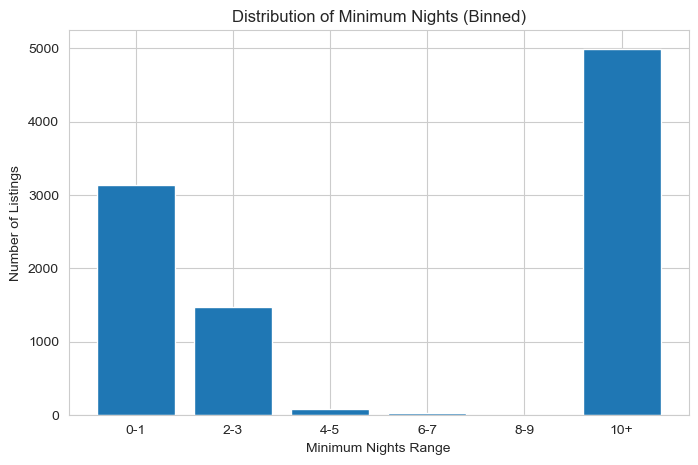

In [66]:

bins = [0, 1, 3, 5, 7, 9, float('inf')]
labels = ['0-1', '2-3', '4-5', '6-7', '8-9', '10+']

# Create binned variable
listings = listings.dropna(subset=['minimum_minimum_nights'])
listings['min_nights_bin'] = pd.cut(listings['minimum_minimum_nights'], bins=bins, labels=labels, right=True, include_lowest=True)

# Count per bin
min_night_counts = listings['min_nights_bin'].value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(8,5))
plt.bar(min_night_counts.index, min_night_counts.values)
plt.title('Distribution of Minimum Nights (Binned)')
plt.xlabel('Minimum Nights Range')
plt.ylabel('Number of Listings')
plt.show()

Inconsistency 3: Accents and weird characters leading to unstandardized entries.
The csv has a lot of weird text given the datasets inability to deal with accents. Therefore it will have to be cleaned
For instance in the list below, Cote des neiges breaks

In [67]:
listings["neighbourhood_cleansed"].head(10)

0                            Ville-Marie
1                            Ville-Marie
2                  Le Plateau-Mont-Royal
3                            Ville-Marie
4              Rosemont-La Petite-Patrie
5                            Ville-Marie
6    Côte-des-Neiges-Notre-Dame-de-Grâce
7                            Ville-Marie
8                           Le Sud-Ouest
9                  Le Plateau-Mont-Royal
Name: neighbourhood_cleansed, dtype: object

| Variables in table above (with inconsistencies)                      | Action                           | Inconsistency Treatment Plan |
|--------------------------------|----------------------------------|------------------------|
| minimum_nights                 | Convert to Binary (restricted vs not)       | Montreal regulations: treat ≥31 nights as “restricted” and others as “not restricted.” |
| Accents | Mapping                        | Changing identified errors to a consistent format |


### Step 1b) Identifying Outliers

In [68]:
# Outlier Detection via IQR Method
outlier_summary = []
for col in numeric_cols: 
    Min = listings[col].min()
    Max = listings[col].max()
    Q1 = listings[col].quantile(0.25)
    Q3 = listings[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = listings[(listings[col] < lower) | (listings[col] > upper)]
    outlier_summary.append({
        'Variable': col,
        'Min': Min,
        'Max': Max,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower_Bound': lower,
        'Upper_Bound': upper,
        'Num_Outliers': len(outliers),
        'Pct_Outliers': round(len(outliers) / len(listings) * 100, 2)
    })

outlier_df = (
    pd.DataFrame(outlier_summary)
      .query("Pct_Outliers > 0")
      .sort_values(by="Pct_Outliers", ascending=False)
)

outlier_df.head(5)

,Variable,Min,Max,Q1,Q3,IQR,Lower_Bound,Upper_Bound,Num_Outliers,Pct_Outliers
13,maximum_nights,1.0,99999.0,365.0,365.0,0.0,365.0,365.0,4504,46.28
41,calculated_host_listings_count_private_rooms,0.0,44.0,0.0,0.0,0.0,0.0,0.0,2260,23.22
9,bathrooms,0.0,16.0,1.0,1.0,0.0,1.0,1.0,1747,17.95
40,calculated_host_listings_count_entire_homes,0.0,139.0,1.0,13.0,12.0,-17.0,31.0,1285,13.20
29,number_of_reviews_ly,0.0,404.0,0.0,13.0,13.0,-19.5,32.5,1268,13.03


| Variables in table above (with outliers)                      | Action                           | Outlier Initial Treatment Plan if chosen as explanatory variable |
|--------------------------------|----------------------------------|------------------------|
| maximum_nights                 | Cap at 90   | We don't want unrealistic numbers like 999 where the host probably mistyped. Per regulation, Airbnb must cap at 90 |
| bedrooms                       | Remove   | Remove extreme outliers. Many of these look like typos (999+ bedrooms). |
| accommodates                   | Remove   | Same as above. Remove extreme outliers.  |
| bathrooms                      | Remove   | Same as above. Remove extreme outliers.  |
| beds                           | Remove   | Same as above. Remove extreme outliers. |
| calculated_host_listings_count | Cap at 90th percentile and bin   | Cap at the 90th-percentile|
| price                          | Log number                       | Model log(price) to handle skew. |
| number_of_reviews              | Binning                       | We bin into five unequally-spaced categories because after the last threshold we expect the marginal value of an incremental review is zero |
| minimum_nights                 | Convert to Binary (restricted vs not)       | Montreal regulations: treat **≥31 nights** as “restricted” and others as “not restricted.” |
| All other columns with outliers | Remove                        | Removed because they add no explanatory value to the model (metadata) or are duplicated elsewhere in the dataset definition. |


### Step 1c) Identifying Duplicates

In [69]:
# Check for duplicate rows
duplicate_count = listings.duplicated().sum()
print(f"Total number of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    print("Preview of duplicate rows:")
    display(listings[listings.duplicated()].head())
else:
    print("No duplicate rows found in the dataset, so no further action needed")

Total number of duplicate rows: 0
No duplicate rows found in the dataset, so no further action needed


### Step 1d) Identifying Missing Values

In [70]:
df = listings.copy()  # your dataframe

# Build summary
missing_value = pd.DataFrame({
    "Variable": df.columns,
    "Num_Missing": df.isna().sum().values
})
missing_value["Pct_Missing"] = (missing_value["Num_Missing"] / len(df) * 100).round(2)

# Sort and keep only columns with any missing values
missing_value = missing_value.sort_values("Pct_Missing", ascending=False).reset_index(drop=True)
missing_value_nonzero = missing_value[missing_value["Num_Missing"] > 0].reset_index(drop=True)

# Show
missing_value_nonzero.head(10)

,Variable,Num_Missing,Pct_Missing
0,calendar_updated,9733,100.00
1,neighbourhood_group_cleansed,9733,100.00
2,host_neighbourhood,6402,65.78
3,neighborhood_overview,5444,55.93
4,neighbourhood,5444,55.93
5,host_about,4786,49.17
6,license,4481,46.04
7,host_location,2459,25.26
8,review_scores_accuracy,1849,19.00
9,review_scores_checkin,1849,19.00


| Variable                     | Amount |   %   | Action                                  | Our treatment plan explanation if variable selected in our model                                                                                                              |
| ---------------------------- | :----: | :---: | --------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------- |
| review_scores_accuracy       |  1849  | 18.99 | Remove                        | Empty in the dataset means no bookings yet so not helpful for our model                                                                                              |
| review_scores_checkin        |  1849  | 18.99 | Remove                        | Empty in the dataset means no bookings yet so not helpful for our model                                                                                               |
| review_scores_value          |  1849  | 18.99 | Remove                        | Empty in the dataset means no bookings yet so not helpful for our model                                                                                               |
| review_scores_location       |  1849  | 18.99 | Remove                        | Empty in the dataset means no bookings yet so not helpful for our model                                                                                               |
| review_scores_cleanliness    |  1849  | 18.99 | Remove                        | Empty in the dataset means no bookings yet so not helpful for our model                                                                                               |
| review_scores_communication  |  1849  | 18.99 | Remove                       | Empty in the dataset means no bookings yet so not helpful for our model                                                                                               |
| last_review                  |  1848  | 18.98 | Remove column                        | Already in other column                                                                                                |
| review_scores_rating         |  1848  | 18.98 | Input Median                        | Empty in the dataset means no bookings yet                                                                                               |
| first_review                 |  1848  | 18.98 | Remove Column                        | Already in other column                                                                                               |
| reviews_per_month            |  1848  | 18.98 | Remove                      | Empty in the dataset means no bookings yet so not helpful for our mode                                                                                               |
| host_response_time           |  1006  | 10.33 | No action                            | Lack of data is understandable. Means host is new. Remove                            |
| host_response_rate           |  1006  | 10.33 | Input median                            | Inputting median so the data can be considered without adding bias                                                                |
| bathrooms                    |   963  |  9.89 | Input median                            | Inputting median so the data can be considered without adding bias                                                                |
| beds                         |   962  |  9.88 | Input median                            | Inputting median so the data can be considered without adding bias                                                                |
| host_acceptance_rate         |   866  |  8.89 | Input median                            | Inputting median so the data can be considered without adding bias                                                                |
| bedrooms                     |   178  |  1.83 | Input median                            | Inputting median so the data can be considered without adding bias                                                                |
| host_is_superhost            |   452  |  4.64 | Use median or K-NN with the criteria as per Airbnb | Airbnb has criteria that defines superhost. We will use median or K-NN to impute this field                                                 |
| price                        |   959  |  9.85 | Remove rows                             | Because price is the dependent variable, imputing it would leak information and distort the loss; exclude for training/validation |
| calendar_updated             |  9737  |  100  | Remove Column                           | Metadata or already in other column                                                                                               |
| neighbourhood_group_cleansed |  9737  |  100  | Remove Column                           | Metadata or already in other column                                                                                               |
| host_neighbourhood           |  6406  | 65.79 | Remove Column                           | Metadata or already in other column                                                                                               |
| neighborhood_overview        |  5447  | 55.94 | Remove Column                           | Metadata or already in other column                                                                                               |
| neighbourhood                |  5447  | 55.94 | Remove Column                           | Metadata or already in other column                                                                                               |
| host_about                   |  4786  | 49.15 | Remove Column                           | Metadata or already in other column                                                                                               |
| license                      |  4481  | 46.02 | Remove Column                           | Metadata or already in other column                                                                                               |
| host_location                |  2459  | 25.25 | Remove Column                           | Metadata or already in other column                                                                                               |
| estimated_revenue_l365d      |   959  |  9.85 | Remove Column                           | Metadata or already in other column                                                                                               |
| description                  |   160  |  1.64 | Remove Column                           | Metadata or already in other column                                                                                               |
| has_availability             |   121  |  1.24 | Remove Column                           | Metadata or already in other column                                                                                               |
| bathrooms_text               |    6   |  0.06 | Remove Column                           | Metadata or already in other column                                                                                               |
| minimum_maximum_nights       |    4   |  0.04 | Remove Column                           | Metadata or already in other column                                                                                               |
| min_nights_bin               |    4   |  0.04 | Remove Column                           | Metadata or already in other column                                                                                               |
| maximum_maximum_nights       |    4   |  0.04 | Remove Column                           | Metadata or already in other column                                                                                               |
| minimum_minimum_nights       |    4   |  0.04 | Remove Column                           | Metadata or already in other column                                                                                               |
| maximum_minimum_nights       |    4   |  0.04 | Remove Column                           | Metadata or already in other column                                                                                                                                                             


### Takeaways from Data Cleaning exploration:

- Several inconsistencies were identified, such as unrealistic `minimum_nights` values and neighbourhood names with accents or formatting issues. These were standardized or mapped into consistent categories.

- Outliers were detected using the IQR method. Variables like `maximum_nights`, `bedrooms`, `accommodates`, and `bathrooms` contained extreme or unrealistic values, which were capped, removed, binned, or converted depending on their role in the model.

- No duplicate rows were found in the dataset, so no additional action was required for this step.

- Many variables contained missing values. Review-related fields showed ~18–19% missingness (due to no bookings yet), so median imputation may be used. Metadata or redundant variables will be removed.

- Several ID-like, URL, or metadata fields will be dropped because they do not contribute to predicting price. Some aggregated fields were also removed to avoid redundancy and multicollinearity.


## 2. Initial Data Cleaning

Each of the issues found above will be addressed. Starting with inconsistencies, then outliers, followed by duplicates, and ending with missing values. At the end we will summarize the actions taken/takeaways

In [71]:
#Creating new data frame to start addressing datatypes for analysis
#creating a "clean" list will allow us to handle data without touching the original one
listings_clean = listings

### Addressing Inconsistencies

1. **Converting fields to appropriate datatypes**: Converting non conventional data like price, date and % format to number

2. **Mapping corrupted names to corrected ones for standarization**: Making sure inconsistencies in names do not affect modelling

3. **Addressing Min night inconstistency by creating a min night variable**: Convert to Binary (restricted vs not)

In [72]:
#Converting date columns to date time type
date_columns = ['last_review', 'first_review', 'host_since']

date_columns = ['last_review', 'first_review', 'host_since']

for col in date_columns:
    listings_clean[col] = pd.to_datetime(listings_clean[col], errors='coerce')


# Converting to Numeric - removing $ and % signs
clean_host_response_rate = listings_clean.host_response_rate.str.replace('%','').str.replace(',','')
listings_clean['host_response_rate']=clean_host_response_rate

clean_host_acceptance_rate = listings_clean.host_acceptance_rate.str.replace('%','').str.replace(',','')
listings_clean['host_acceptance_rate']=clean_host_acceptance_rate

clean_price = listings_clean.price.str.replace('$','').str.replace(',','').astype(float)
listings_clean['price']=clean_price


# Creating a regulated vs not regulated column to address Montreal Min night regulations: If listing is allowed to book for <31 nights its "not regulated", else its "regulated"
listings_clean["min_nights_regulation"] = np.where(
    listings_clean["minimum_nights"] < 31, "not regulated", "regulated"
)


In [73]:
# Dictionary mapping corrupted names to corrected ones
fix_map = {
    "CÃ´te-des-Neiges-Notre-Dame-de-GrÃ¢ce": "Cote-des-Neiges–Notre-Dame-de-Grace",
    "Baie-d'UrfÃ©": "Baie-d’Urfe",
    "RiviÃ¨re-des-Prairies-Pointe-aux-Trembles": "Riviere-des-Prairies–Pointe-aux-Trembles",
    "CÃ´te-Saint-Luc": "Cote-Saint-Luc",
    "L'ÃŽle-Bizard-Sainte-GeneviÃ¨ve": "L’Ile-Bizard–Sainte-Genevieve",
    "Saint-LÃ©onard": "Saint-Leonard",
    "MontrÃ©al-Ouest": "Montreal-Ouest",
    "MontrÃ©al-Nord": "Montreal-Nord",
    "MontrÃ©al-Est": "Montreal-Est"
}

# Apply replacements
listings_clean["neighbourhood_cleansed"] = (
    listings_clean["neighbourhood_cleansed"].replace(fix_map))

In [74]:
# Creating a regulated vs not regulated column to address Montreal Min night regulations: If listing is allowed to book for <31 nights its "not regulated", else its "regulated"
listings_clean["min_nights_regulation"] = np.where(
    listings_clean["minimum_nights"] < 31, "not regulated", "regulated"
)

In [75]:
#Adressing Missing Values in host_response_time

#This feature is categorical and the data is ordinal, so it would be best to map to an hour scale and then impute the median

# Mapping dictionary
response_map = {
    'within an hour': 1,
    'within a few hours': 3,
    'within a day': 24,
    'a few days or more': 72
}

# Map and overwrite the original column in place
listings_clean['host_response_time'] = listings_clean['host_response_time'].map(response_map)

### Addressing Outliers

1. **Capping maximum nights available to rent to 90**: Per the definition in Quebec, anyone renting for less than 90 days is defined as short term rentee.
   
2. **Drop any features beyond 3 standard deviations for bedrooms, bathrooms, acommodates and beds**: After searching the URLs, we find these to be typos or big hotel chains so outside of our scope

   
3. **Dropped any rows where the hosts had more listings than 99.7 percentile (3std)**: By looking at the data, these also represented hotels and may distort the model from its purpose.

   
4. **Logged price and number of reviews**: Prevents bias from very expensive AirBnBs.


In [76]:
# Max nights capped at 365 to remove unrealistic values

listings_clean['maximum_nights'] = listings['maximum_nights'].clip(upper=90)

## sanity check: listings_clean[["maximum_nights"]].head(40)

In [77]:
# Beds/Accomodates/Bathrooms outlier handling:
#Finding extreme outliers (hotels). Anything at 3 std  will be removed.
house_features_to_check = ["bedrooms", "bathrooms", "accommodates", "beds"]
# Get averages and spreads
averages = listings[house_features_to_check].mean()
spreads  = listings[house_features_to_check].std()

# Cap values above +3 std or below -3 std
for feature in house_features_to_check:
    lower = averages[feature] - 3 * spreads[feature]
    upper = averages[feature] + 3 * spreads[feature]
    listings_clean[feature] = listings_clean[feature].clip(lower=0, upper=upper) # Im setting lower = 0 cause we cant have negative bathrooms


In [78]:
#dropping where hosts have more listings than 99.7 percentile
p99_chlc = listings["calculated_host_listings_count"].quantile(0.997)
listings_clean["calculated_host_listings_count"] = (
    listings["calculated_host_listings_count"].clip(upper=p99_chlc)
)


In [79]:
# price and number of reviews outlier handling. Log the values to avoid heavy weight to anomalies. Creating new columns rather than rewriting just in case

listings_clean["price_log"] = np.where(listings_clean["price"] > 0,
                                       np.log(listings_clean["price"]), np.nan)
listings_clean["number_of_reviews_log"] = np.log1p(listings_clean["number_of_reviews"])

### Addressing Missing Data

1. **We remove metadata and redundant categorical fields that do not help explain price**: Some columns may look useful at first (for example, neighbourhood), but these are widely empty or contain weird characters. The actual cleaned version we use is neighbourhood_cleansed. In these cases, we drop the raw or duplicate columns and keep only the relevant, cleaned variable.

2. **Removing any data without price**: Each row must have the dependent variable.

3. **Handling missing Is_Super_Host**: Because host_is_superhost is a host-level attribute, we use any known value from one listing to fill all listings for the same host. If a host has no known value at all, we default it to False since an unknown status is more consistent with not being a Superhost (new hosts)

4. **Dropping listings with 0 reviews**: Listings with missing review information have never been booked, meaning they are too new to have a market-validated price. Since our model aims to learn pricing patterns from mature Airbnbs with real booking history, we remove these immature listings to avoid training on prices that haven’t been tested by the market.

5. **Median imputation** Given the small amount missing and given we removed outliers, we will imputate median for missing bathrooms, beds, bedrooms, review_scores and reviews_per_month

6. **Mode Imputation**: For host_response_time we will use the mode given its categorical "within an hour", "within a few hours", "within a day"

In [80]:
# Removing metadata and redundant cateogircal fields
#Columns to drop
drop_in_listings_clean = [
    'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description',
    'neighborhood_overview', 'picture_url', 'host_url', 'host_name',
    'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url',
    'host_neighbourhood', 'host_total_listings_count', 'host_verifications',
    'neighbourhood', 'neighbourhood_group_cleansed',
    'bathrooms_text', 'minimum_minimum_nights', 'maximum_minimum_nights',
    'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm',
    'maximum_nights_avg_ntm', 'calendar_updated', 'availability_30', 'availability_60',
    'availability_90', 'calendar_last_scraped',
    'number_of_reviews_ltm', 'number_of_reviews_l30d', 'availability_eoy',
    'number_of_reviews_ly', 'estimated_occupancy_l365d', 'estimated_revenue_l365d',
    'first_review', 'license',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms', 'has_availability'
]

# Drop them from the DataFrame (ignore missing just in case)
listings_clean = listings_clean.drop(columns=drop_in_listings_clean, errors='ignore')

In [81]:
# Dropping any value without prices to avoid distorting prediction
listings_clean = listings_clean.dropna(subset=["price"]).copy()

In [82]:
#Address missing values in 'host_is_superhost'

# 1. Fill NaNs based on other listings from the same host
# Groups by 'host_id' and takes the first non-null value
# (e.g., 't', 'f') and broadcasts it to all rows for that host.
# If a host only has NaN values, they will remain NaN.
listings_clean['host_is_superhost'] = listings_clean.groupby('host_id')['host_is_superhost'].transform('first')

print(f"Missing values after grouping: {listings_clean['host_is_superhost'].isna().sum()}")

# 2. Fill any remaining NaNs
# If a host had NaN for *all* their listings, we must make a default assumption.
# The safest assumption is that if the status is unknown, they are 'f' (false),
# as Superhost is an earned status.
listings_clean['host_is_superhost'] = listings_clean['host_is_superhost'].fillna('f')

print(f"Missing values after final fill: {listings_clean['host_is_superhost'].isna().sum()}")

# Check the result
print(listings_clean['host_is_superhost'].value_counts())



print("Remaining rows:", len(listings_clean))

Missing values after grouping: 427
Missing values after final fill: 0
host_is_superhost
f    5468
t    3306
Name: count, dtype: int64
Remaining rows: 8774


In [83]:
#dropping where there are no reviews.
listings_clean = listings_clean[listings_clean['number_of_reviews'] > 0].reset_index(drop=True)

In [84]:
# Columns where we'll fill missing values with the median
cols_to_fill_with_median = [
  "host_response_rate", "bathrooms",
    "beds", "host_acceptance_rate", "bedrooms", "review_scores_accuracy", "review_scores_checkin", "review_scores_value",
    "review_scores_location", "review_scores_cleanliness",
    "review_scores_communication",
    "review_scores_rating", "reviews_per_month","host_response_time"
]

# Fill missing values using each column's median
for col in cols_to_fill_with_median:
    listings_clean[col] = pd.to_numeric(listings_clean[col], errors="coerce")
    median_value = listings_clean[col].median()
    listings_clean[col] = listings_clean[col].fillna(median_value)

In [85]:
# Fill missing values in 'host_response_time' with the mode
mode_value = listings_clean['host_response_time'].mode()[0]
listings_clean['host_response_time'] = listings_clean['host_response_time'].fillna(mode_value)

#### Confirming Missing Data Handling

In [86]:
df = listings_clean.copy()  # your dataframe

# Build summary
missing_value = pd.DataFrame({
    "Variable": df.columns,
    "Num_Missing": df.isna().sum().values
})
missing_value["Pct_Missing"] = (missing_value["Num_Missing"] / len(df) * 100).round(2)

# Sort and keep only columns with any missing values
missing_value = missing_value.sort_values("Pct_Missing", ascending=False).reset_index(drop=True)
missing_value_nonzero = missing_value[missing_value["Num_Missing"] > 0].reset_index(drop=True)

if missing_value_nonzero.empty:
    print("No missing data found.")
else:
    print("Found missing data:")
    display(missing_value_nonzero)

No missing data found.


In [87]:
listings_clean.head()

,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,min_nights_bin,min_nights_regulation,price_log,number_of_reviews_log
0,125031,2010-05-14,1.0,100.0,100.0,t,2,t,t,Ville-Marie,...,4.78,4.82,4.67,f,2,2.66,0-1,regulated,4.919981,6.190315
1,125031,2010-05-14,1.0,100.0,100.0,t,2,t,t,Ville-Marie,...,4.83,4.87,4.72,f,2,0.96,0-1,not regulated,5.720312,5.056246
2,381468,2011-02-07,24.0,90.0,56.0,t,8,t,t,Le Plateau-Mont-Royal,...,4.90,4.88,4.77,f,8,0.42,10+,regulated,5.036953,3.970292
3,163569,2010-07-11,72.0,0.0,6.0,f,3,t,t,Ville-Marie,...,4.82,4.65,4.41,f,3,0.10,10+,regulated,3.850148,2.890372
4,231694,2010-09-11,1.0,100.0,100.0,t,2,t,t,Rosemont-La Petite-Patrie,...,4.99,4.85,4.93,t,2,1.90,2-3,not regulated,4.962845,5.831882


In [88]:
listings_clean.shape

(7170, 39)

In [89]:
listings_clean.isna().sum()


host_id                           0
host_since                        0
host_response_time                0
host_response_rate                0
host_acceptance_rate              0
host_is_superhost                 0
host_listings_count               0
host_has_profile_pic              0
host_identity_verified            0
neighbourhood_cleansed            0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
beds                              0
amenities                         0
price                             0
minimum_nights                    0
maximum_nights                    0
availability_365                  0
number_of_reviews                 0
last_review                       0
review_scores_rating              0
review_scores_accuracy            0
review_scores_cleanliness   

In [90]:
#List of all remaining columns. cols_list will be handy in the EDA section below
cols_list = listings_clean.columns.tolist()

### Takeaways from Initial Data Cleaning

- Several fields required datatype conversion before analysis. Non-standard formats such as price strings, percentage strings (e.g., "95%"), and date fields were cleaned and converted into numeric or datetime types to ensure they can be used correctly in modelling.

- Inconsistent or corrupted categorical values—such as neighbourhood names with accents or spelling variations—were standardized using mapping dictionaries so that identical categories are not treated as separate groups.

- A new regulation-based variable was created to address Montreal’s minimum-night rules. Listings allowing fewer than 31 nights were labeled as “not regulated,” and those with 31 or more as “regulated.” This helps capture local policy effects during modelling.

- Outliers were handled carefully across different variables. Maximum nights were capped at 90 based on Quebec rental rules, and extreme values for bedrooms, bathrooms, accommodates, and beds were removed using a 3-standard-deviation rule. Host listing counts above the 99.7th percentile were also removed since they represent hotels or commercial operators rather than typical Airbnbs.

- Price and number_of_reviews were log-transformed to reduce the impact of extreme values and make the distribution more suitable for regression models.

- Metadata and redundant fields such as URLs, IDs, picture links, raw neighbourhood fields, and duplicate aggregated variables were removed since they do not help predict price and add unnecessary noise or multicollinearity.

- Missing categorical information for `host_is_superhost` was resolved using host-level logic. If any listing from the same host had a known Superhost status, that value was propagated across all their listings. Remaining unknown hosts were assigned as non-Superhosts.

- Listings with zero reviews were removed because they have never been booked and therefore do not reflect a market-validated price. Including them would introduce nois


# Exploratory Data Analysis (EDA)

With the datacleaning completed we move on to the EDA. Here we explore the variables and chose the most adequate variables to run the model. We first explore the **target** variable (price), followed by the independent variables

## Exploring Target Variable
- Visualizing the right-skewed "price" target variable.
- As seen in the first graph, most AirBnBs are under 188 dollars (mean) and the median is 134 dollars,
- It is very right skewed.
- To reduce the influence of expensive Airbnbs in the model, we log transorm the price variable to make the distribution more Normal

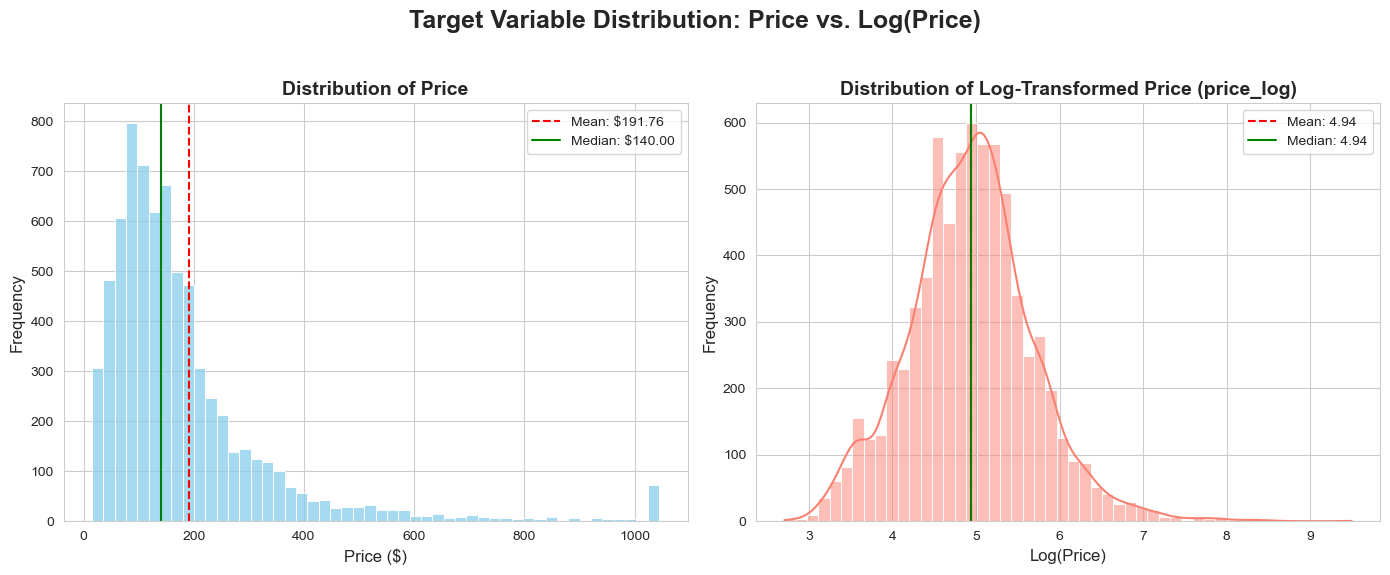

In [91]:
# Set the figure size for better readability
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# Histogram for "price"
#Clipping outliers at 99th percentile for better visualization
ax1 = plt.subplot(1, 2, 1)
price_99th = listings_clean['price'].quantile(0.99)

sns.histplot(listings_clean['price'].clip(0, price_99th), bins=50, kde=False, ax=ax1, color='skyblue')
ax1.set_title('Distribution of Price', fontsize=14, fontweight='bold')
ax1.set_xlabel('Price ($)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.axvline(listings_clean['price'].mean(), color='red', linestyle='--', label=f"Mean: ${listings_clean['price'].mean():.2f}")
ax1.axvline(listings_clean['price'].median(), color='green', linestyle='-', label=f"Median: ${listings_clean['price'].median():.2f}")
ax1.legend()


# Histogram for Log-Transformed Price 
ax2 = plt.subplot(1, 2, 2)
sns.histplot(listings_clean['price_log'], bins=50, kde=True, ax=ax2, color='salmon')
ax2.set_title('Distribution of Log-Transformed Price (price_log)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Log(Price)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.axvline(listings_clean['price_log'].mean(), color='red', linestyle='--', label=f"Mean: {listings_clean['price_log'].mean():.2f}")
ax2.axvline(listings_clean['price_log'].median(), color='green', linestyle='-', label=f"Median: {listings_clean['price_log'].median():.2f}")
ax2.legend()


# --- Final Touches ---
plt.suptitle('Target Variable Distribution: Price vs. Log(Price)', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Exploring Candidate Features
- Now we start viewing all independent variables remaining after having droped redundant categories and metadata during the Data Cleaning stage

In [92]:
#First we check all the remaining features
features_df = pd.DataFrame({
    'Variable Name': cols_list,
    'Data Type': [str(df[col].dtype) for col in cols_list] 
})

# Sort the dataframe by data type
features_df = features_df.sort_values(by='Data Type')

num_features = features_df.shape[0]
print(f"The number of candidate features is: {num_features}\n")

features_df.style.hide(axis='index')


The number of candidate features is: 39



Variable Name,Data Type
min_nights_bin,category
host_since,datetime64[ns]
last_review,datetime64[ns]
price,float64
reviews_per_month,float64
review_scores_value,float64
review_scores_location,float64
review_scores_communication,float64
review_scores_checkin,float64
review_scores_cleanliness,float64


From this exploration, our goal is to identify which variables will be included in the final model. In the next stage of the EDA, we organize the feature selection process by variable type. Specifically, we evaluate and select features separately for three groups: Numerical, DateTime, and Categorical variables.


## Exploring and selecting Numeric columns

#### To select the Numeric features we will
1. Look at the correlation between each variable and price.
2. Visualize at the relationship with our logged version of price through scatter plots
3. Analyze multicollinearity and linearity assumptions

In [93]:
# Select numeric types and drop the 'price' and 'price_log', as these are the target variable and not features
numeric_cols = listings_clean.select_dtypes(include=[np.number]) \
                            .drop(columns=['price', 'price_log'], errors='ignore') \
                            .columns.to_list()

num_numeric = len(numeric_cols)
print(f"The dataset has {num_numeric} numeric candidate features.")


The dataset has 25 numeric candidate features.


In [94]:
#1. Look at the Pearson correlation between each numerical variable and price
correlation_results = []

for col in numeric_cols:
    #Skipping 'regulated' because it is technically a numerical data type but since it has binary values, will examine with categorical feature
    if col == 'regulated':
        continue
    # Ensuring price_log and the feature have same number of observations (no null values)
    valid_data = listings_clean[['price_log', col]].dropna()
    
    #Ensuring at least two data points for each of feature and target
    if len(valid_data) < 2: 
        continue

    # Calculate Pearson's r and p-value
    r, p_val = stats.pearsonr(valid_data[col], valid_data['price_log'])
    
    # Store data the data in a list
    correlation_results.append({
        'Feature': col,
        'Pearson R': r,
        'Abs R': abs(r),
        'P-Value': p_val
    })

# Convert list to DataFrame and sort by correlation strength
corr_df = pd.DataFrame(correlation_results)
corr_df = corr_df.sort_values(by='Abs R', ascending=False).reset_index(drop=True)

# Filter the dataframe for rows where P-Value is less than 0.05 and only include top 10
significant_features = corr_df[corr_df['P-Value'] < 0.05].head(10).set_index('Feature')

display(significant_features.drop(columns=['Abs R']))

,Pearson R,P-Value
Feature,,
accommodates,0.628767,0.000000e+00
beds,0.537721,0.000000e+00
bedrooms,0.531368,0.000000e+00
bathrooms,0.355728,6.815842e-213
minimum_nights,-0.236418,1.187931e-91
number_of_reviews_log,0.227078,1.634167e-84
reviews_per_month,0.208866,1.675849e-71
host_acceptance_rate,0.192097,1.463161e-60
review_scores_cleanliness,0.181703,2.855851e-54


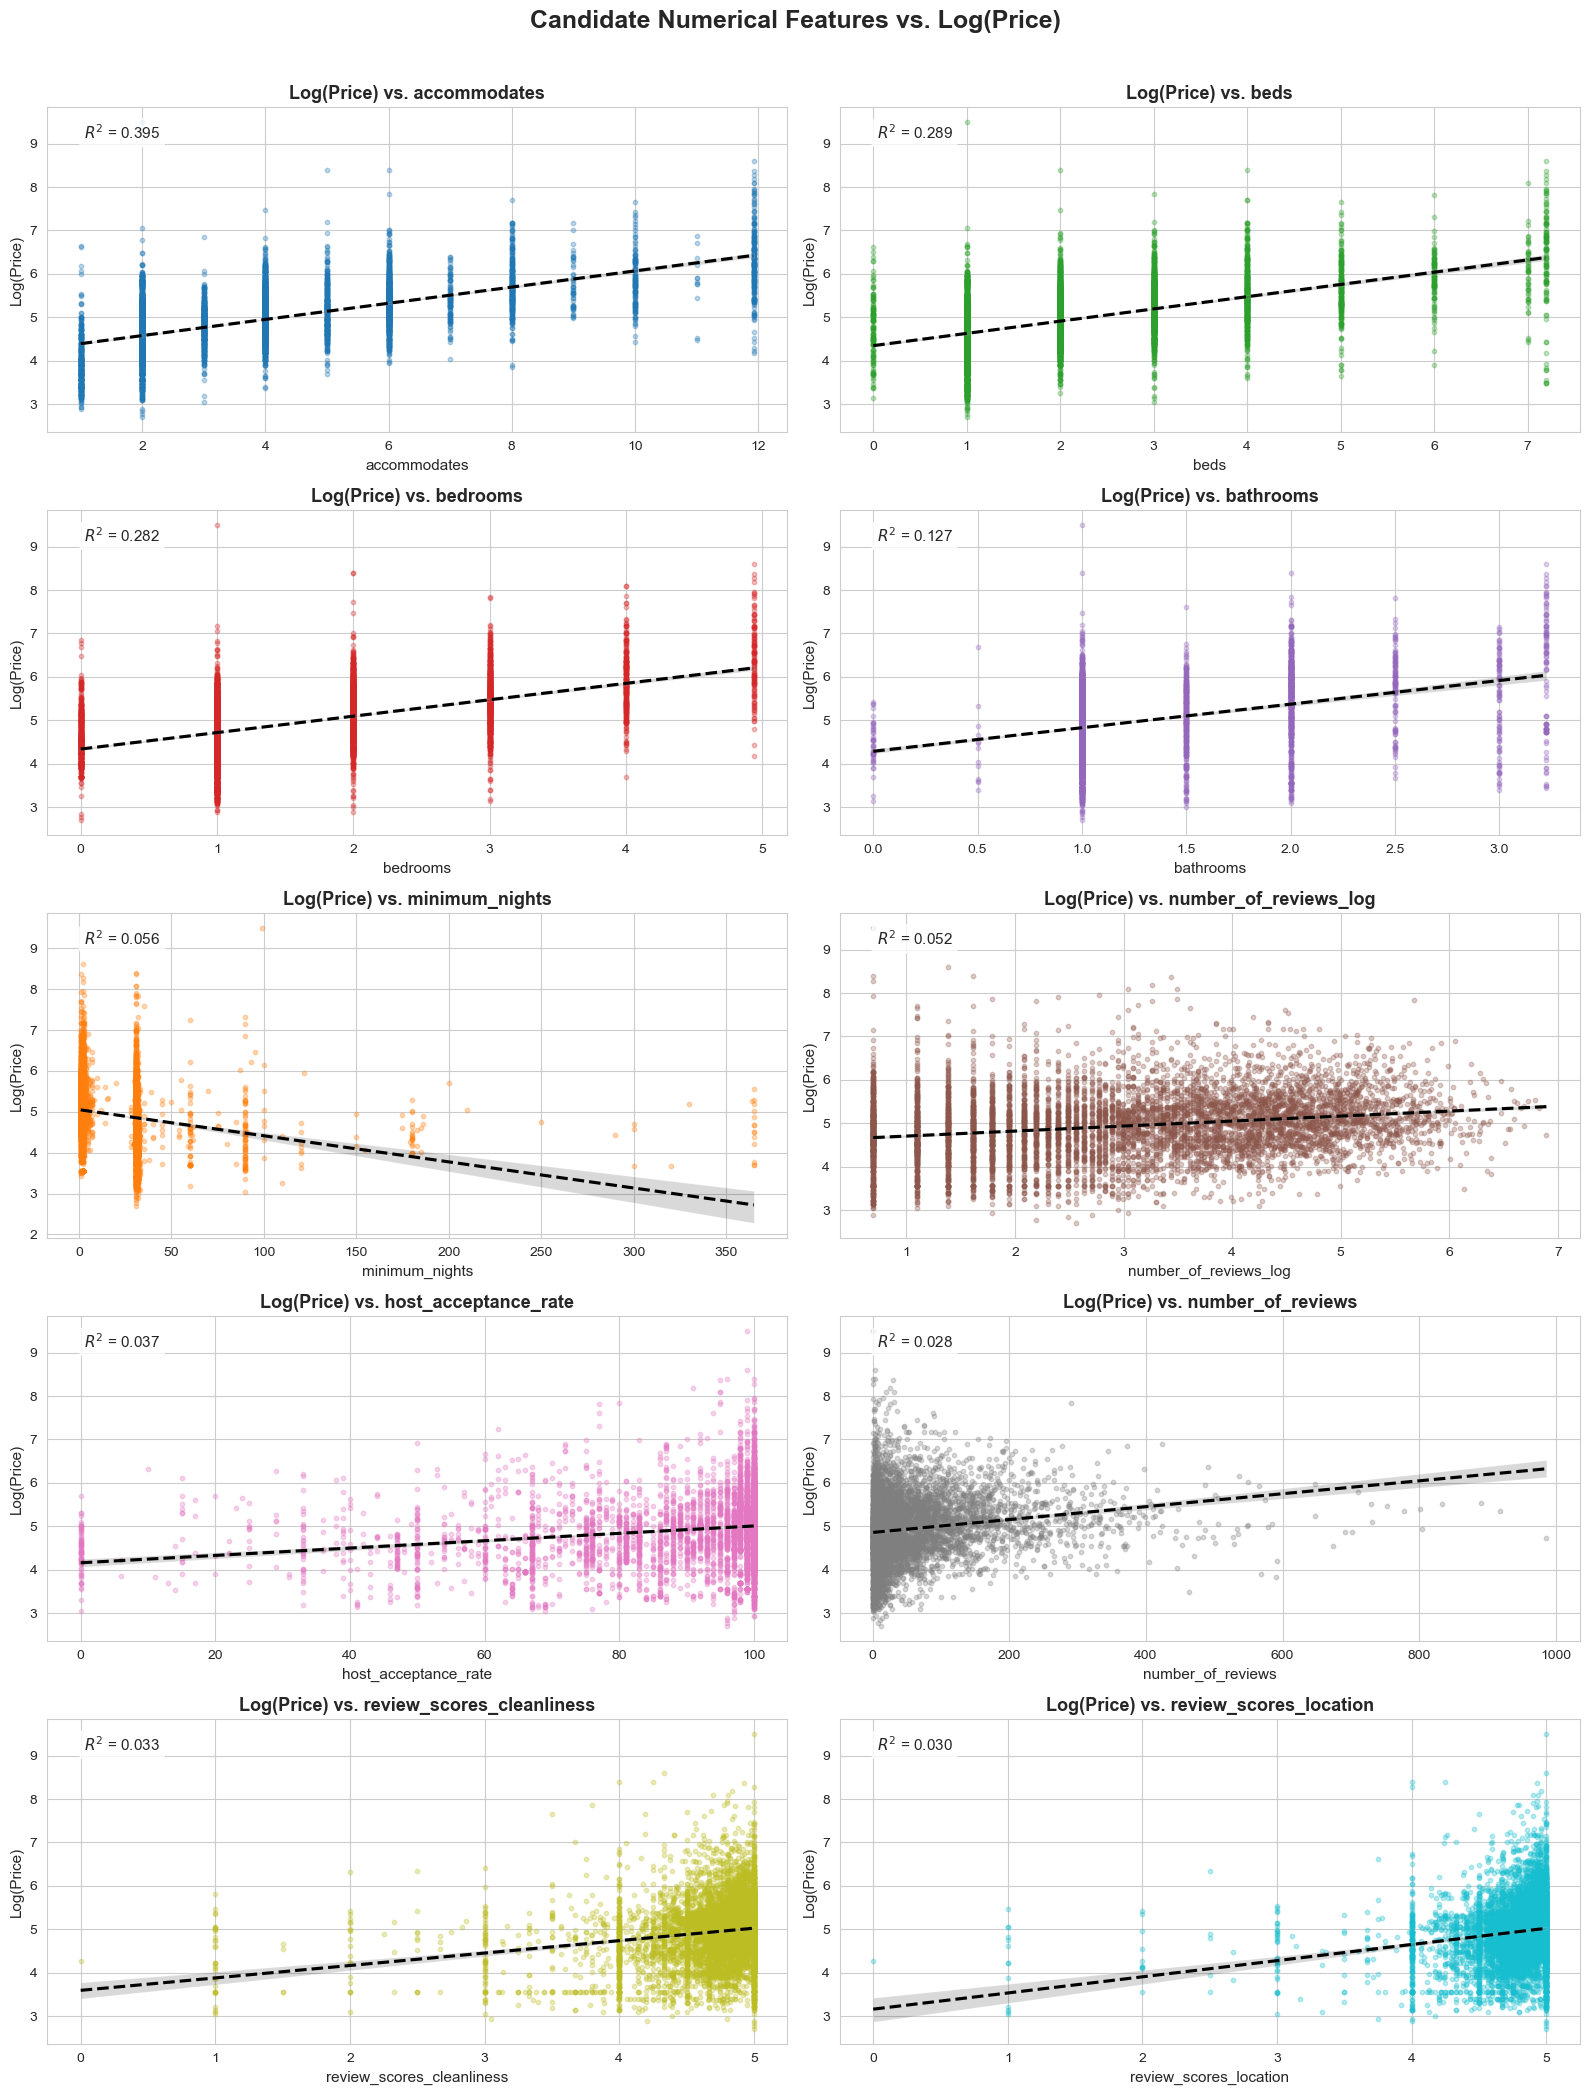

In [95]:
#2. Building scatterplots
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

sns.set_style("whitegrid")

# Features to plot vs log(price)
features_to_plot = [
    'accommodates',
    'beds',
    'bedrooms',
    'bathrooms',
    'minimum_nights',
    'number_of_reviews_log',
    'host_acceptance_rate',
    'number_of_reviews',
    'review_scores_cleanliness',
    'review_scores_location'
]

# One distinct color per feature
colors = [
    'tab:blue',
    'tab:green',
    'tab:red',
    'tab:purple',
    'tab:orange',
    'tab:brown',
    'tab:pink',
    'tab:gray',
    'tab:olive',
    'tab:cyan'
]

# Sanity check (optional)
assert len(features_to_plot) == len(colors), "features_to_plot and colors must match in length"

# Create subplots: 5 rows x 2 columns = 10 plots
fig, axes = plt.subplots(5, 2, figsize=(16, 22))
fig.suptitle('Candidate Numerical Features vs. Log(Price)', fontsize=18, fontweight='bold')

axes_flat = axes.flatten()

for i, (feature, color) in enumerate(zip(features_to_plot, colors)):
    ax = axes_flat[i]

    if feature in listings_clean.columns:
        # Scatter + regression line
        sns.regplot(
            data=listings_clean,
            x=feature,
            y='price_log',               # your target
            ax=ax,
            color=color,
            scatter_kws={'alpha': 0.3, 's': 10},
            line_kws={'color': 'black', 'linestyle': '--'}
        )

        # Compute Pearson r and R^2
        r, p = pearsonr(listings_clean[feature], listings_clean['price_log'])
        r2 = r ** 2

        # Add annotation with R^2
        ax.annotate(
            f"$R^2$ = {r2:.3f}",
            xy=(0.05, 0.95),
            xycoords='axes fraction',
            ha='left',
            va='top',
            fontsize=11,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8)
        )

        ax.set_title(f'Log(Price) vs. {feature}', fontsize=13, fontweight='bold')
        ax.set_xlabel(feature, fontsize=11)
        ax.set_ylabel('Log(Price)', fontsize=11)
    else:
        ax.set_title(f"Column '{feature}' not found", fontsize=13, fontweight='bold')
        ax.text(
            0.5, 0.5, f"'{feature}' not in DataFrame",
            ha='center', va='center',
            transform=ax.transAxes, color='red'
        )

# Tight layout so titles/labels don’t overlap the suptitle
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


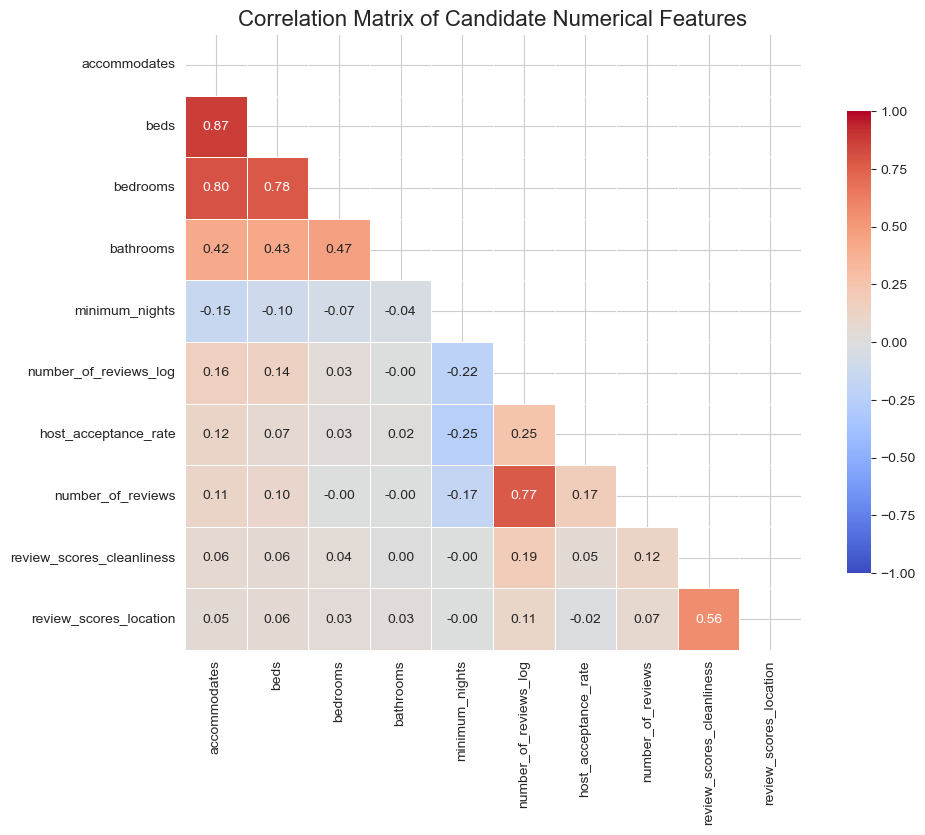

In [96]:
#3. Multicollinearity Check
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Your candidate features
candidate_numeric = [
    'accommodates',
    'beds',
    'bedrooms',
    'bathrooms',
    'minimum_nights',
    'number_of_reviews_log',
    'host_acceptance_rate',
    'number_of_reviews',
    'review_scores_cleanliness',
    'review_scores_location'
]

# Compute correlation matrix using only those features
corr = listings_clean[candidate_numeric].corr()

# Mask upper triangle (avoid duplicates)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75}
)

plt.title("Correlation Matrix of Candidate Numerical Features", fontsize=16)
plt.show()


### Numerical Features Explored and Final Decision

In this section, we explored all numerical variables and examined their correlations with log(price), their scatterplot relationships, and their multicollinearity patterns. The variables investigated were:

- accommodates  
- beds  
- bedrooms  
- bathrooms  
- minimum_nights  
- number_of_reviews_log  
- host_acceptance_rate  
- number_of_reviews  
- review_scores_cleanliness  
- review_scores_location  

#### Overall Findings

#### 1. Positive Correlated Variables
Most numerical features showed positive correlations with log(price). This result is intuitive: larger listings, such as those with more guests, bedrooms, beds, or bathrooms, typically command higher prices. Listings with more reviews or higher review scores also showed mild positive relationships with price.

#### 2. The Special Case of minimum_nights
The negative correlation between minimum_nights and log(price is not meaningful in the context of our dataset. From an economic perspective, requiring longer minimum stays should decrease demand and therefore decrease prices. However, in Montreal, many hosts are legally required to set minimum stays above 31 nights. This regulation inflates the numeric values of minimum_nights in a way that does not reflect true host preferences or market behavior.

Because these values are driven by policy rather than pricing strategy, the raw minimum_nights variable introduces distorted correlations and should not be used as a predictive numeric feature. To properly capture the regulatory effect, we engineered a binary feature, regulated, indicating whether a listing meets the >31-night regulatory threshold. This engineered feature provides a more accurate and interpretable representation, and the original numeric minimum_nights variable is removed from modeling.

#### Overall
To determine which numerical features to retain, we used a combination of:

- Pearson correlations with log(price)  
- Scatterplot inspection to evaluate the direction and form of relationships  
- Multicollinearity checks to avoid redundant variables such as beds and bedrooms  
- Domain knowledge, particularly regarding Montreal regulations affecting minimum-night requirements  

The table below summarizes the choises made


| Feature Name              | Keep/Drop | Explanation                                                                                     |
|---------------------------|-----------|-------------------------------------------------------------------------------------------------|
| accommodates              | Keep      | Strongest correlation with log(price); best single proxy for listing size.                     |
| bedrooms                  | Drop      | High multicollinearity (>0.8) with accommodates; redundant size information.                   |
| beds                      | Drop      | High multicollinearity (>0.8) with accommodates; redundant and adds no new variance.           |
| bathrooms                 | Keep      | Provides additional explanatory power beyond accommodates; only moderate multicollinearity.    |
| minimum_nights            | Drop      | Montreal regulations force >31-night minimums, distorting the numeric signal; not price-driven.|
| number_of_reviews_log     | Keep      | Reflects listing maturity/popularity; positive relationship with log(price) & low collinearity.|
| host_acceptance_rate      | Keep      | Moderate positive relationship; captures host reliability and listing quality.                 |
| review_scores_cleanliness | Keep      | Low multicollinearity; retains service-quality signal despite weaker correlation.              |
| review_scores_location    | Keep      | Captures neighborhood desirability; low multicollinearity and relevant for pricing.            |
| regulated                 | Keep      | Engineered binary feature replacing minimum_nights; directly captures Montreal’s rental rules. |


## Exploring and Selecting Date Time Features

In [97]:
date_feature_dict = [
    {
        "Feature Name": "host_since", 
        "Keep/Drop": "Keep", 
        "Explanation": "Hosts who have been using Airbnb longer have more credibility with guests and may have optimized their pricing"
    },
    {
        "Feature Name": "last_review", 
        "Keep/Drop": "Keep", 
        "Explanation": "Indicates recent occupancy, suggesting there is demand for this Airbnb"
    }
]

pd.set_option('display.max_colwidth', None)
date_feature_df = pd.DataFrame(date_feature_dict)

# Display the dataframe
display(date_feature_df)

#Select these date features to be used later
date_features_chosen = listings_clean.select_dtypes(include=['datetime']) \
                            .columns.to_list()

,Feature Name,Keep/Drop,Explanation
0,host_since,Keep,Hosts who have been using Airbnb longer have more credibility with guests and may have optimized their pricing
1,last_review,Keep,"Indicates recent occupancy, suggesting there is demand for this Airbnb"


### DateTime Features and Final Decision

Unlike standard numerical features, raw DateTime values are not used directly in a linear regression model. Their value comes from the information they represent, such as host experience or recent listing activity.  

#### Overall Decision

#### 1. host_since  
This feature represents how long a host has been active on Airbnb. Hosts with longer activity history may have more experience, more credibility with guests, and better optimized pricing strategies. This makes host_since a relevant and meaningful predictor of price.

#### 2. last_review  
This feature indicates the recency of guest activity for a listing. A recent review signals ongoing demand and recent occupancy. For this reason, last_review provides useful information for price modeling.

#### Final Approach to DateTime Feature Selection

Because raw DateTime fields are not modeled directly, the decision focuses on the conceptual meaning and interpretability of each feature. Both host_since and last_review provide clear behavioral and temporal signals that may influence pricing. Therefore, both features are retained.


## Exploring and Selecting Categorical Variables

### Exploration on Categorical Variables

To evaluate which categorical variables should be included in predicting the price of the Airbnb, we conduct a similar exploratory analysi to the numerical feature selection

### Goals of This Section
1. Identify and inspect all categorical variables in the dataset.
2. Evaluate whether different classes have statistically significant differences in log(price).
3. Visualize the relationship between each categorical variable and log(price) using boxplots.
4. Select the categorical variables most appropriate for modeling.

### Difference between this section and Numerical Section: 
- For categorical variables, numerical correlation metrics like Pearson R are not meaningful. For this reason, we use statistical tests we have learned in this class and others (t-tests for binary variables and ANOVA for multi-class variables) to determine whether differences in log(price) across categories are statistically significant.
- We also use boxplots allow us to visually assess how strongly price varies across different classes and help validate whether the class-level differences detected by statistical tests are practically meaningful.
- While our numerical EDA above focused on linear strength and multicollinearity, this section focuses on whether categories create distinct price segments that justify inclusion in the model.
 



In [98]:
# Identify categorical columns
categorical_cols = listings_clean.select_dtypes(include=['object', 'category']).columns.to_list()

#Include the 'regulated' features as categorical because its encoded as binary
categorical_cols.append('min_nights_regulation')

num_categorical = len(categorical_cols)

print(f"The number of categorical variables to evaluate is: {num_categorical}\n")

for var in categorical_cols:
    num_classes = listings_clean[var].nunique()
    print(f"Number of classes for {var}: {num_classes}")

The number of categorical variables to evaluate is: 11

Number of classes for host_is_superhost: 2
Number of classes for host_has_profile_pic: 2
Number of classes for host_identity_verified: 2
Number of classes for neighbourhood_cleansed: 32
Number of classes for property_type: 39
Number of classes for room_type: 4
Number of classes for amenities: 6640
Number of classes for instant_bookable: 2
Number of classes for min_nights_bin: 5
Number of classes for min_nights_regulation: 2
Number of classes for min_nights_regulation: 2


### Sample Data for Each Categorical Column

In [99]:
for var in categorical_cols:
    print(f"Sample data for: {var}")
    print(listings_clean[var].head())
    print("\n")

Sample data for: host_is_superhost
0    t
1    t
2    t
3    f
4    t
Name: host_is_superhost, dtype: object


Sample data for: host_has_profile_pic
0    t
1    t
2    t
3    t
4    t
Name: host_has_profile_pic, dtype: object


Sample data for: host_identity_verified
0    t
1    t
2    t
3    t
4    t
Name: host_identity_verified, dtype: object


Sample data for: neighbourhood_cleansed
0                  Ville-Marie
1                  Ville-Marie
2        Le Plateau-Mont-Royal
3                  Ville-Marie
4    Rosemont-La Petite-Patrie
Name: neighbourhood_cleansed, dtype: object


Sample data for: property_type
0             Entire rental unit
1                    Entire home
2             Entire rental unit
3    Private room in rental unit
4             Entire rental unit
Name: property_type, dtype: object


Sample data for: room_type
0    Entire home/apt
1    Entire home/apt
2    Entire home/apt
3       Private room
4    Entire home/apt
Name: room_type, dtype: object


Sample data 

### Checking for Difference in "price_log" between Classes in Each Categorical Variable
- Using a t-test or ANOVA test to check for statistically significant differences between the relationship of different classes of a categorical variable and the log(price)
- Checks whether the categorical feature would be predictive of log(price)

In [100]:
#Uses statistical test to check if there is a diffference in 'price_log' across different categories of several categorical variables
# If two classes only, performs a t-test, otherwise uses one-way ANOVA to compare multiple classes

results_data = []

for col in categorical_cols:
    temp = listings_clean[[col, 'price_log']].dropna()

    if temp[col].nunique() < 2:
        continue

    p_val = None 

    # t-test for binary variables
    if temp[col].nunique() == 2:
        groups = temp.groupby(col, observed=True)['price_log']
        cats = list(groups.groups.keys())
        t_stat, p_val = stats.ttest_ind(groups.get_group(cats[0]), 
                                        groups.get_group(cats[1]), 
                                        equal_var=False)
        
    # ANOVA for multi-category variables 
    else:
        groups = [g['price_log'].values for _, g in temp.groupby(col, observed=True)]
        f_stat, p_val = stats.f_oneway(*groups)
    
   #Dictionary with results
    results_data.append({
        'Feature': col, 
        'P_Value': p_val
    })


results_df = pd.DataFrame(results_data)

# Sort categorical variables by low to high P values
results_df = results_df.sort_values(by='P_Value', ascending=True).reset_index(drop=True)


print(results_df)

                   Feature        P_Value
0                room_type   0.000000e+00
1            property_type   0.000000e+00
2           min_nights_bin   0.000000e+00
3    min_nights_regulation  2.748607e-195
4    min_nights_regulation  2.748607e-195
5   neighbourhood_cleansed  5.828161e-183
6                amenities  5.577084e-152
7         instant_bookable   1.221370e-28
8        host_is_superhost   4.208579e-27
9     host_has_profile_pic   1.485379e-01
10  host_identity_verified   1.507087e-01


Each of the categorical features displayed differences in the relationship between classes and the log(price), except for the 'host_identity_verified' feature. Next, we will visualize these class differences as boxplots, omitting "host_identity-verified". Features with a high number of classes will also not be visualized.

### Visualizing Categorical Variables Relationship with Log(Price)
- Created separate, larger visuals for "neighbourhood_cleansed" and "property_type" due to high cardinality

C:\Users\hp\AppData\Local\Temp\ipykernel_44452\3617534421.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_prices = listings_clean.groupby(col)['price_log'].mean()


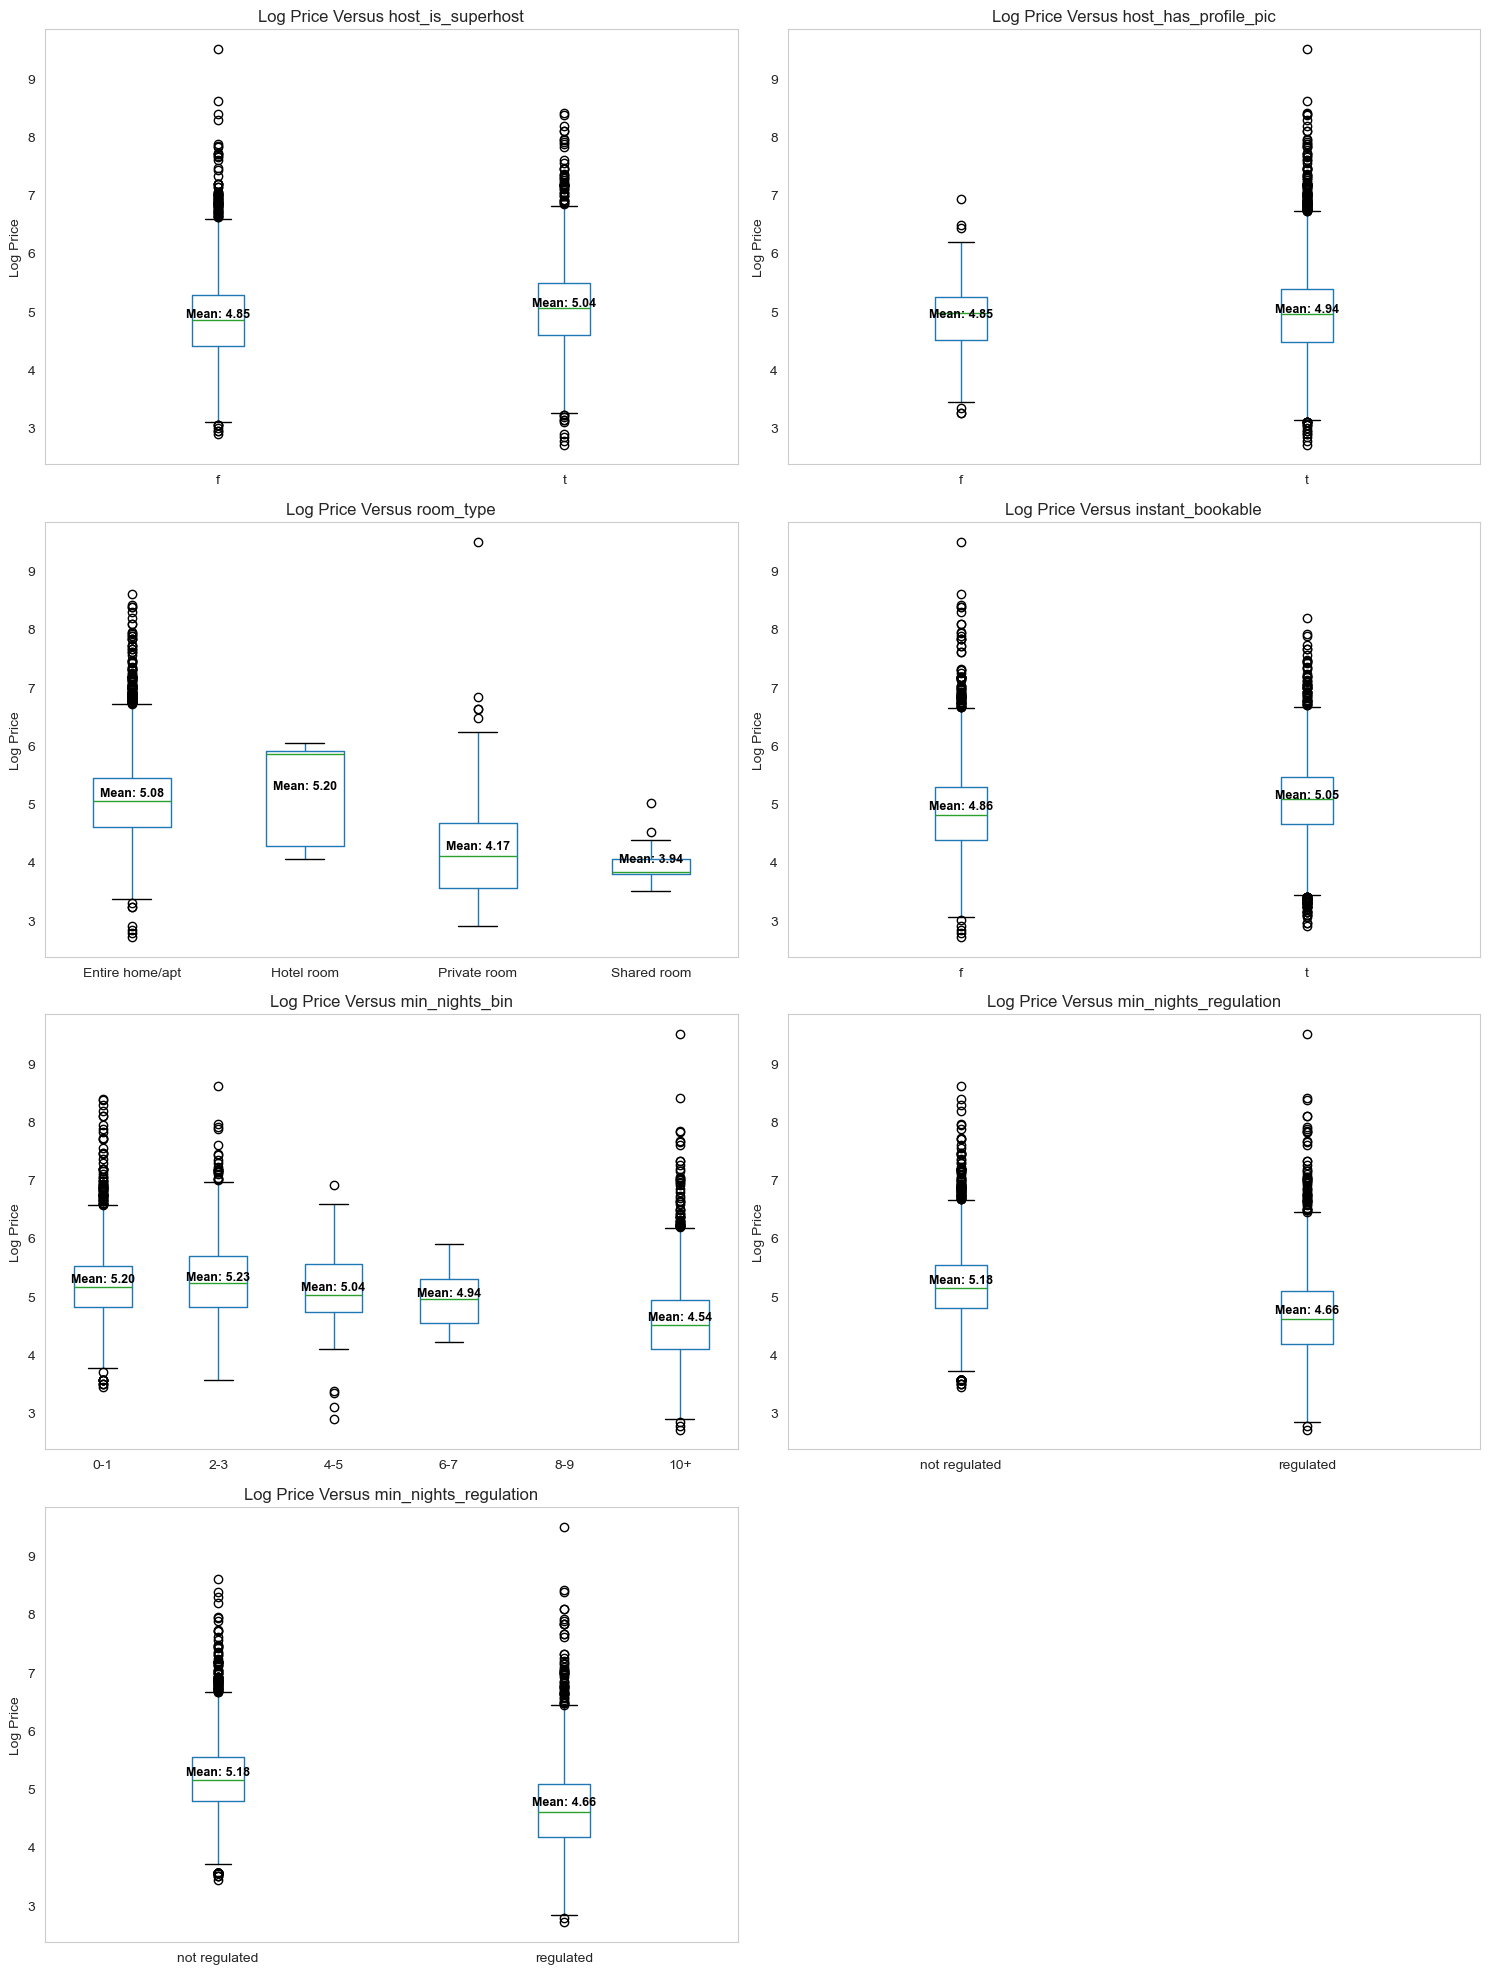

In [101]:
import math

cols_to_plot = categorical_cols.copy()
if "host_identity_verified" in cols_to_plot:
    cols_to_plot.remove("host_identity_verified")

if "neighbourhood_cleansed" in cols_to_plot:
    cols_to_plot.remove("neighbourhood_cleansed")

if "property_type" in cols_to_plot:
    cols_to_plot.remove("property_type")

# Needed to figure out how many rows the plots needs
valid_cols = [col for col in cols_to_plot if listings_clean[col].nunique() < 100]

# Calculates how many rows needed if we had two boxplots per row
n_cols = 2 
n_rows = math.ceil(len(valid_cols) / n_cols)

# 4. Create the figure
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))

axes_flat = axes.flatten()

for i, col in enumerate(valid_cols):
    ax = axes_flat[i]  
    
    #Calculate average price
    avg_prices = listings_clean.groupby(col)['price_log'].mean()

    avg_prices.index = avg_prices.index.astype(str)
    
    # Plot onto the correct axis
    listings_clean.boxplot(column='price_log', by=col, ax=ax)
    
    plot_labels = [label.get_text() for label in ax.get_xticklabels()]
    
    #Creates a label on the plot with the mean value of the class
    for j, label in enumerate(plot_labels):
        if label in avg_prices:
            mean_val = avg_prices[label]
            ax.text(j + 1, mean_val, 
                    f'Mean: {mean_val:.2f}', 
                    ha='center', va='bottom', 
                    color='black', fontweight='bold', fontsize=9,)

    # Formatting specific to the subplot
    ax.set_title(f'Log Price Versus {col}')
    ax.set_xlabel('') 
    ax.set_ylabel('Log Price')
    ax.grid(False)

# Remove any empty subplots if there are an odd number

for j in range(len(valid_cols), len(axes_flat)):
    fig.delaxes(axes_flat[j])

# Remove the automatic pandas title
plt.suptitle('') 

# Adjust spacing so titles don't overlap
plt.tight_layout()
plt.show()

<Figure size 1200x2000 with 0 Axes>

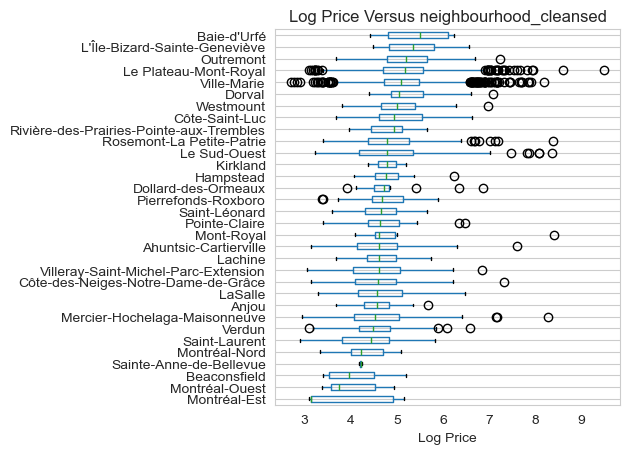

<Figure size 1200x2000 with 0 Axes>

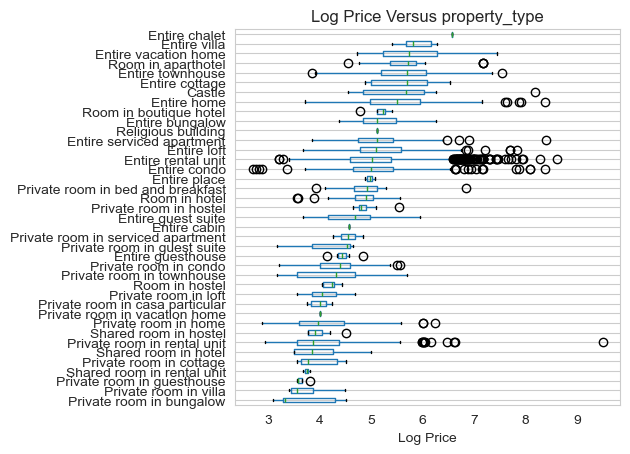

In [102]:
cols_to_plot = ['neighbourhood_cleansed', 'property_type']


for col in cols_to_plot:
    # Sort by price ascending
    sorted_order = listings_clean.groupby(col)['price_log'].median().sort_values(ascending=True).index
    
    # Apply Categorical Order
    temp_df = listings_clean.copy()
    temp_df[col] = pd.Categorical(temp_df[col], categories=sorted_order, ordered=True)
    
    plt.figure(figsize=(12, 20)) 
    
   
    temp_df.boxplot(column='price_log', by=col, vert=False)
    
   
    plt.title(f'Log Price Versus {col}')
    plt.suptitle('') 
    plt.xlabel('Log Price') 
    plt.ylabel('') 
    
    plt.grid(axis='x') 
    
    plt.tight_layout() 
    plt.show()


## Spatial Analysis of Montreal Neighbourhoods

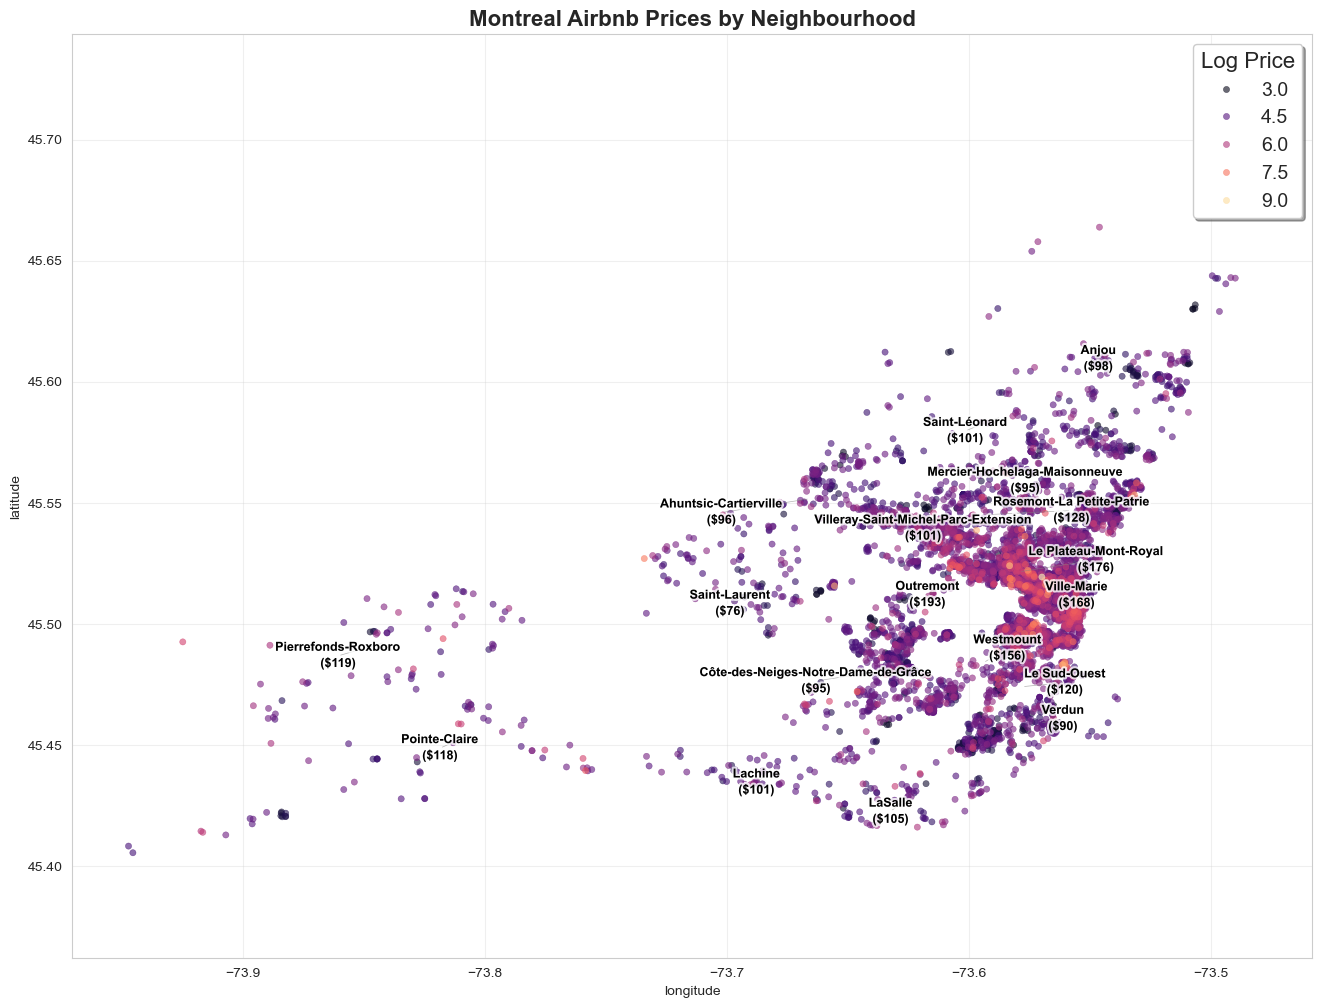

In [103]:
# Sort data by price_log
listings_sorted = listings_clean.sort_values('price_log', ascending=True)


plt.figure(figsize=(16, 12)) 

# Create the scatter plot, coloured by price
sns.scatterplot(
    data=listings_sorted,
    x='longitude',
    y='latitude',
    hue='price_log',
    palette='magma',       
    alpha=0.6,             
    s=20,                 
    edgecolor=None
)

# Aggregate data for labelling
neighborhood_stats = listings_clean.groupby('neighbourhood_cleansed', as_index=False).agg(
    latitude=('latitude', 'mean'),
    longitude=('longitude', 'mean'),
    price_log=('price_log', 'mean'),
    listing_count=('price_log', 'count')  
)

texts = [] 

# Loop through neighbourhoods and create the neighbourhood labels
for i, row in neighborhood_stats.iterrows():
    if row['listing_count'] > 20: # Adjusted threshold for better visibility
        
        avg_price = np.exp(row['price_log'])
        label_text = f"{row['neighbourhood_cleansed']}\n(${avg_price:.0f})"
        
        # Store the text object in the 'texts' list
        txt = plt.text(
            x=row['longitude'], 
            y=row['latitude'], 
            s=label_text, 
            fontsize=9, 
            fontweight='bold', 
            color='black',
            ha='center', 
            va='center',
            zorder=10 
        )
        txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white', alpha=0.8)])
        texts.append(txt)

# Adjust neighbourhood labels so they dont overlap
adjust_text(texts, 
            arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.6), 
            expand_points=(2,2), 
            lim=100)


# Final Formatting
plt.title('Montreal Airbnb Prices by Neighbourhood', fontsize=16, fontweight='bold')

plt.legend(
    title='Log Price', 
    loc='upper right', 
    fontsize=14, 
    title_fontsize=16, 
    frameon=True,     
    framealpha=1,      
    facecolor='white',
    shadow=True        
)
plt.grid(True, alpha=0.3)
plt.axis('equal') 
plt.show()

#### Interpretation
The listing price is clearly correlated with geographic locations. We see a dense central cluster of high-price listings, corresponding to "Ville-Marie" and "Le Plateau-Mont-Royal" neighbourhoods. As listings move to neighbourhoods further from downtown, we see the prices drop significantly. This visual supports using neighbourhood_cleansed as a feature for pricing prediction. 

## Categorical Features Explored and Final Decision

The categorical variables investigated were:

- host_is_superhost  
- host_has_profile_pic  
- host_identity_verified  
- neighbourhood_cleansed  
- property_type  
- room_type  
- amenities  
- instant_bookable  
- min_nights_bin  
- min_nights_regulation  
- regulated (engineered feature)

### Overall Findings

#### 1. Most Categorical Variables Show Meaningful Differences in Price

For the majority of categorical features, t-tests or ANOVA returned very small p-values (< 0.05), confirming statistical significance. Boxplots further confirmed the magnitude and direction of these differences.

Examples include:
- **room_type**: Entire homes are priced much higher than private or shared rooms, as expected.  
- **neighbourhood_cleansed**: Strong spatial variation exists across Montreal neighbourhoods.   
- **amenities**: Listings offering more amenities generally command higher prices.

#### 2. Engineered Feature: regulated

The variable regulated (1 = min_nights ≥ 31, 0 = otherwise) was engineered to capture Montreal’s rental regulations.  
ANOVA and boxplots show clear price differences between regulated and non-regulated listings. This engineered feature replaces the original min_nights_bin and min_nights_regulation categorical fields, which were redundant or low-signal.

#### 3. Features Showing Weak or dropped

Two variables did not show strong statistical significance or practical value:
- **host_identity_verified**: P-value > 0.05 and negligible class separation.  
- **min_nights_bin** and **min_nights_regulation**: Both redundant due to the engineered regulated variable.

These features are removed from modeling.

### Overall

The table below summarizes the final decisions.

| Feature Name            | Keep/Drop | Explanation                                                                                     |
|-------------------------|-----------|-------------------------------------------------------------------------------------------------|
| property_type           | Keep      | Statistically significant class differences and boxplot confirms.                               |
| room_type               | Keep      | Statistically significant class differences and boxplot confirms. Intuitive that room type drives price. |
| min_nights_bin   | Drop      | Created during EDA for exploration only. Not needed for modeling, as its information is fully captured by the min_nights_regulation feature |
| min_nights_regulation   | Keep      | Statistically significant class differences and boxplot confirms. Longer minimum stays would lower price. |
| neighbourhood_cleansed  | Keep      | Price differences between neighbourhoods visible in boxplot and map.                            |
| amenities               | Keep      | Amenities are an important driver of price, although transformations will be necessary.         |
| host_is_superhost       | Keep      | Statistically significant difference in price between superhosts and non-superhosts. Logical driver of price. |
| instant_bookable        | Keep      | Statistically significant, despite small magnitude.                                             |
| host_has_profile_pic    | Keep      | Statistically significant difference. With online scams rising, profile pictures increase customer trust. |
| host_identity_verified  | Drop      | Not statistically significant (P-Value > 0.05).                                                 |


# Summary of all Features Chosen for Regression Model



| **Numerical Variables Chosen**             | Keep/Drop | Explanation |
|---------------------------|-----------|-------------|
| accommodates              | Keep      | Strongest correlation with log(price); best single proxy for listing size. |
| bathrooms                 | Keep      | Provides additional explanatory power beyond accommodates; only moderate multicollinearity. |
| number_of_reviews_log     | Keep      | Reflects listing maturity/popularity; positive relationship with log(price) & low collinearity. |
| host_acceptance_rate      | Keep      | Moderate positive relationship; captures host reliability and listing quality. |
| review_scores_cleanliness | Keep      | Low multicollinearity; retains service-quality signal despite weaker correlation. |
| review_scores_location    | Keep      | Captures neighborhood desirability; low multicollinearity and relevant for pricing. |


&nbsp;

| **Categorical Variables Chosen** | **Actions to Take** |
| :--- | :--- |
| property_type | Binning property types to handle high cardinality (40 classes) |
| neighbourhood_cleansed | Grouping neighbourhoods together to handle high cardinality (32 classes) |
| amenities | Will have to be engineered into a numerical variable (more below) |
| room_type | None |
| min_nights_regulation | Engineered from the Numerical variable min_nights |
| host_is_superhost | None |
| instant_bookable | None |
| host_has_profile_pic | None |

&nbsp;

| **Date Time Variables Chosen** | **Actions to Take** |
| :--- | :--- |
| host_since | Transform feature to be numerical for model, such as days_since_signing_up |
| last_review | Transform feature to be numerical for model, such as days_since_last_review |


**List of Numeric Features**: numeric_features_chosen <br>
**List of Categorical Features**: categorical_features_chosen <br>
**List of Date Time Features**: date_features_chosen


As seen above, some of the selected variables need engineering. Specifically, property_type, neighbourhood_cleansed, and amenities. There is high cardinality and we need to fix the data for the model to run. This section explains how this is done for neighbourhood_cleansed, property_type and amenities. 

#### 1. Clustering Neighbourhoods Using K-Means: 

The original dataset contains 32 different neighbourhoods in Montréal. Using all 32 as categorical variables would create a high-cardinality feature, which can add unnecessary noise to the model.  


To simplify the variable,, we use one of the machine-learning techniques learned in class. Specifically. K-Means clustering.  However we considered this as the most statistically accurate (vs median imputation) since it uses actual price data to form groups. 


Our ultimate goal is to allow the model to work with a new variable that represents neighbourhoods not as 32 labels, but as a few meaningful price zones such as:

- High-price areas  
- Mid-price areas  
- Low-price areas  

This reduces complexity, handles high cardinality, and provides a clearer and more interpretable signal for regression.


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

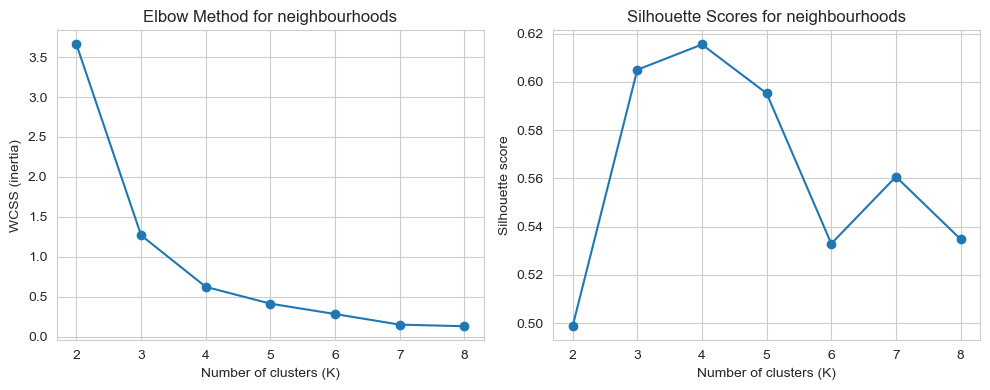

Chosen K for neighbourhoods: 4


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,neighbourhood_cleansed,median_price_log,nb_cluster,neighbourhood_zone
0,Ahuntsic-Cartierville,4.610145,0,Zone_3
1,Anjou,4.564131,0,Zone_3
2,Baie-d'Urfé,5.503759,1,Zone_4
3,Beaconsfield,3.951244,2,Zone_2
4,Côte-Saint-Luc,4.945049,1,Zone_4


In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1. Aggregate to neighbourhood level (1D feature for clustering)
nb_prices = (
    listings_clean
    .groupby("neighbourhood_cleansed")["price_log"]
    .median()
    .reset_index(name="median_price_log")
)

X = nb_prices[["median_price_log"]].values  # shape (n_neighbourhoods, 1)

# 2. Try several K values and store WCSS (inertia) + Silhouette
K_range = range(2, 9)   # K = 2,...,8
wcss = []               # Within-Cluster Sum of Squares (Elbow)
sil_scores = []         # Silhouette scores

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X)
    wcss.append(km.inertia_)
    sil_scores.append(silhouette_score(X, labels))

# 3. Plot Elbow curve
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(list(K_range), wcss, marker="o")
plt.xlabel("Number of clusters (K)")
plt.ylabel("WCSS (inertia)")
plt.title("Elbow Method for neighbourhoods")
plt.grid(True)

# 4. Plot Silhouette scores
plt.subplot(1,2,2)
plt.plot(list(K_range), sil_scores, marker="o")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Scores for neighbourhoods")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Choose K that balances Elbow + Silhouette (example: best silhouette)
best_k = K_range[int(np.argmax(sil_scores))]
print(f"Chosen K for neighbourhoods: {best_k}")

# 6. Fit final K-Means and attach cluster labels back to the neighbourhoods
final_km = KMeans(n_clusters=best_k, random_state=42)
nb_prices["nb_cluster"] = final_km.fit_predict(X)

# 7. (Optional) Order clusters by median price and map to labels
centers = final_km.cluster_centers_.ravel()
order = np.argsort(centers)  # from lowest to highest price
label_map = {order[i]: f"Zone_{i+1}" for i in range(len(order))}

nb_prices["neighbourhood_zone"] = nb_prices["nb_cluster"].map(label_map)

# 8. Merge back to main dataframe if needed
listings_clean = listings_clean.merge(
    nb_prices[["neighbourhood_cleansed", "neighbourhood_zone"]],
    on="neighbourhood_cleansed",
    how="left"
)

nb_prices.head()


#### Interpreting the K-Means Results for neihbourghood

After calculating the median log(price) for each neighbourhood, we tested different values of K (number of clusters) using two diagnostics:

1. **Elbow Method** – to show where adding more clusters stops improving the model.
2. **Silhouette Score** – to measure how separate and well-defined the neighbourhood clusters are.

Both methods indicated that **K = 4** gives the best balance between cluster quality and simplicity:

- The Elbow curve flattens around 4–5 clusters.
- The Silhouette score peaks at K = 4.

This means:
- With too few clusters (K=2 or 3), distinct neighbourhoods get forced together.
- With too many clusters (K=6 to 8), the groups become noisy and unstable.
- K = 4 produces clean, meaningful groups that reflect Montréal’s price structure.

Each neighbourhood was then assigned to one of four price-based zones (e.g., Zone_1 (least expensive), Zone_2, Zone_3, Zone_4 (most expensive)).  

### 2. Clustering property type using manual domain-driven mapping

Unlike neighbourhoods property types cannot be clustered using algorithms like K-means, because they do not behave like numeric variables. A condo is not “closer” to a cabin, and a hotel room is not “further” from a bungalow in any measurable way. Property types represent styles of accommodation, not numeric distances. Also, some categories have very few listings (e.g., “Castle”, “Religious building”), while many “private room” variants vary widely within the same label. These inconsistencies mean we did not use K-means.
To address this, we apply a manual, domain-driven mapping. Instead of creating 39+ categories or relying on numeric clustering, we consolidate all Airbnb property types into a small set of intuitive groups that reflect how guests actually choose accommodations. Here are some advantages of this method:
 
- Manual mapping respects the real-world differences between accommodation types.
- Avoids unstable or misleading automated clusters. For instance, rare categories (e.g. “Castle”) cannot meaningfully guide a model.
- Produces clear and business-friendly feature groups


  
The final mapped categories are intuitive and easy to interpret:
- Entire home / apartment  
- Private room  
- Hotel / hostel room  
- Shared room  
- Unique or luxury stay  

These groups align with how Airbnb users would think about accommodation choices, making the variable easier to explain to non-technical stakeholders.


In [105]:
# Define mapping dictionary
property_mapping = {
    # Entire units
    'Entire home': 'Entire home/apt',
    'Entire apartment': 'Entire home/apt',
    'Entire condo': 'Entire home/apt',
    'Entire loft': 'Entire home/apt',
    'Entire bungalow': 'Entire home/apt',
    'Entire house': 'Entire home/apt',
    'Entire guest suite': 'Entire home/apt',
    'Entire serviced apartment': 'Entire home/apt',
    'Entire townhouse': 'Entire home/apt',
    'Entire vacation home': 'Entire home/apt',
    'Entire chalet': 'Entire home/apt',
    'Entire cabin': 'Entire home/apt',
    'Entire cottage': 'Entire home/apt',

    # Private rooms
    'Private room': 'Private room',
    'Private room in condo': 'Private room',
    'Private room in apartment': 'Private room',
    'Private room in townhouse': 'Private room',
    'Private room in guest suite': 'Private room',
    'Private room in bungalow': 'Private room',
    'Private room in villa': 'Private room',
    'Private room in vacation home': 'Private room',

    # Hotel / hostel categories
    'Room in hotel': 'Hotel/hostel room',
    'Room in hostel': 'Hotel/hostel room',
    'Room in boutique hotel': 'Hotel/hostel room',
    'Room in aparthotel': 'Hotel/hostel room',
    'Hotel room': 'Hotel/hostel room',
    'Shared room in hotel': 'Hotel/hostel room',

    # Shared rooms
    'Shared room': 'Shared room',
    'Shared room in hostel': 'Shared room',
    'Shared room in rental unit': 'Shared room',

    # Unique / luxury / rare
    'Castle': 'Unique/luxury',
    'Religious building': 'Unique/luxury',
    'Yurt': 'Unique/luxury',
    'Treehouse': 'Unique/luxury',
    'Tiny house': 'Unique/luxury',
    'Boat': 'Unique/luxury',
    'Earth house': 'Unique/luxury'
}

# Apply mapping
listings_clean['property_type_binned'] = listings_clean['property_type'].map(property_mapping)

# Handle unexpected categories
listings_clean['property_type_binned'] = listings_clean['property_type_binned'].fillna('Unique/luxury')

# View distribution
print(listings_clean['property_type_binned'].value_counts())


property_type_binned
Unique/luxury        5489
Entire home/apt      1340
Hotel/hostel room     236
Private room           94
Shared room            11
Name: count, dtype: int64


### 3.Engineering a Numerical Feature From the Amenities Field

The amenities column contains long comma-separated lists of amenities (e.g., “Wifi, Heating, Kitchen, TV, …”).  
Creating a separate binary column for each amenity would introduce dozens of new variables, many of which appear in very few listings.  
This would lead to:

- High dimensionality and model instability  
- Multicollinearity issues in a linear regression model  

Instead, we convert the amenities text into a single numerical feature:

amenities_count = number of amenities listed for each Airbnb.

This captures listing richness/quality and is strongly linked to price, while keeping the model simple, stable, and interpretable.



In [106]:
import ast

def count_amenities(amenities_string):
    if pd.isna(amenities_string):
        return 0
    try:
        # Airbnb amenities are stored as a string representation of a Python list → convert safely
        items = ast.literal_eval(amenities_string)
        return len(items)
    except:
        # Fallback: split by comma
        return len(str(amenities_string).split(","))

listings_clean["amenities_count"] = listings_clean["amenities"].apply(count_amenities)

listings_clean["amenities_count"].head()


0    58
1    65
2    29
3    21
4    49
Name: amenities_count, dtype: int64

### 4.Converting the datetime variables into numerical variables to be able to run using statsmodel library


In this step, we transformed date columns (host_since and last_review) into numerical values so they can be used in a linear regression model. Statsmodels and most regression algorithms cannot directly interpret dates, so they must be converted into meaningful numeric variables.

#### What we did:

1. **Converted the date columns from text to actual datetime objects**  
   Using pd.to_datetime(), we instructed Python to treat these columns as real dates instead of strings.

2. **Selected a reference date**  
   We used the most recent last_review date in the dataset as an anchor point. This gives us a consistent timeline to measure from.

3. **Calculated how many days have passed since each date**  
   - days_since_host_signup = number of days since the host first joined Airbnb  
   - days_since_last_review = number of days since the listing last received a review  
   These numerical values capture how “old” or “recent” each listing or host is.

4. **Removed the original datetime columns**  
   After creating numerical versions of the features, the original text-based date columns were dropped because regression cannot use them directly.


In summary, we converted raw date strings into useful numerical predictors that the regression model can understand and learn from.Linear regression requires numeric inputs. Dates must be translated into numbers.


In [107]:
import pandas as pd

# Convert to datetime
listings_clean["host_since"] = pd.to_datetime(listings_clean["host_since"], errors="coerce")
listings_clean["last_review"] = pd.to_datetime(listings_clean["last_review"], errors="coerce")

# Reference date = date of data extraction (or max date in dataset)
ref_date = listings_clean["last_review"].max()

# Convert to numeric (days)
listings_clean["days_since_host_signup"] = (ref_date - listings_clean["host_since"]).dt.days
listings_clean["days_since_last_review"] = (ref_date - listings_clean["last_review"]).dt.days

# Drop original datetime columns (not needed anymore)
listings_clean = listings_clean.drop(columns=["host_since", "last_review"])


Finally, we create a list of each feature that will be used in our model

In [108]:
# FINAL FEATURES FOR MODELING

numeric_features_chosen = [
    "accommodates",
    "bathrooms",
    "number_of_reviews_log",
    "host_acceptance_rate",
    "review_scores_cleanliness",
    "review_scores_location",
    "amenities_count",        # numeric variable created from amenities
    "days_since_host_signup",
    "days_since_last_review"
]

categorical_features_chosen = [
    "property_type_binned",   # manually mapped property type
    "room_type",              
    "neighbourhood_zone",     # K-means clustering result
    "host_is_superhost",
    "instant_bookable",
    "host_has_profile_pic",
    "min_nights_regulation" # engineered feature
]

# (No datetime features remain because they were transformed to numerical)


# Modeling

## Model 1A. Linear Regression Model (OLS) Using Statsmodels

Now that all variables have been cleaned, transformed, and encoded properly, we can fit a linear regression model to understand how each feature influences **log(price)**.We use statsmodels OLS, the same library used in class

### What we expect
-  H1: Listing characteristics such as accommodates, bathrooms, amenities_count, and neighbourhood_zone will show strong, positive, and statistically significant effects on log(price).  
  These variables directly relate to the size, quality, and desirability of the listing, so they should increase predicted price.

- H2: Host-related features (host_since, host_is_superhost, host_has_profile_pic) will show weaker or mixed effects. 
  These variables may influence trust and booking likelihood, but their relationship with price is expected to be smaller than property or location features.

Below, we now fit the model and interpret it. We will test these hypotheses using a train/test split to evaluate out-of-sample performance.


In [109]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score


all_features = numeric_features_chosen + categorical_features_chosen


target_col = "price_log"   # your log(price) column

model_df = listings_clean[all_features + [target_col]].copy()

# Make sure numeric columns are really numeric
model_df[numeric_features_chosen] = model_df[numeric_features_chosen].apply(
    pd.to_numeric, errors="coerce"
)

# Drop rows with missing target or predictors (simplest approach for now)
model_df = model_df.dropna(subset=numeric_features_chosen + [target_col])


# 3. One-hot encode categorical columns so everything becomes numeric
model_df_encoded = pd.get_dummies(
    model_df,
    columns=categorical_features_chosen,
    drop_first=True,      # avoid dummy trap / perfect multicollinearity
    dtype=float           # ensure float dtype, not bool
)

# Separate X and y
X = model_df_encoded.drop(columns=[target_col])
y = model_df_encoded[target_col].astype(float)


# 4. Train / test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# 5. Fit OLS on TRAIN set only
import statsmodels.api as sm

# Add intercept to TRAIN data
X_train_sm = sm.add_constant(X_train)          # add constant column
ols_model = sm.OLS(y_train, X_train_sm).fit()  # fit OLS

# Show OLS summary (this is on the TRAIN data)
print(ols_model.summary())

# 6. Evaluate model on TEST set
# Add intercept to TEST data (must match train design matrix)
X_test_sm = sm.add_constant(X_test, has_constant="add")

# Predict on test set
y_pred_test = ols_model.predict(X_test_sm)

# Compute metrics
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print("\nTest RMSE:", rmse_test)
print("Test R²:", r2_test)

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     440.7
Date:                Sat, 22 Nov 2025   Prob (F-statistic):               0.00
Time:                        23:44:01   Log-Likelihood:                -3528.7
No. Observations:                5736   AIC:                             7105.
Df Residuals:                    5712   BIC:                             7265.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

### Summary Interpretation of Regression Results

#### **1. Most Important and Impactful Variables**

A few variables stand out as the strongest and most meaningful predictors of log(price) and are statistically significant:

**accommodates**  
Larger listings charge substantially higher prices. 

**bathrooms**  
More bathrooms strongly and significantly increase price. This effectively captures comfort and size.

**amenities_count**  
Listings offering more amenities command higher nightly rates. This engineered variable performs exactly as intended.

**review_scores_cleanliness & review_scores_location**  
Quality and guest-perceived desirability translate directly into higher prices.

**number_of_reviews_log**  
Listings with more reviews tend to be higher-priced—reflecting trust, demand, and reputation dynamics.

**neighbourhood_zone categories**  
Location-driven clustering meaningfully separates higher-priced zones from lower-priced ones. The engineered zoning variable is working very well. Cheaper zones have a beta of -0.03 and more expensive (Zone 4) of 0.58

**min_nights_regulation_regulated (important to highlight)**  
This variable captures the impact of Montreal’s 31-night policy.  
Regulated listings show significantly lower nightly prices, which makes perfect economic sense: these listings behave like long-term rentals and therefore price differently.


#### **2. Variables With Low Significance or Unstable Effects**
Some predictors show weak, noisy, or inconsistent results:

- **days_since_host_signup**  
- **host_is_superhost**  
- **Some room_type and property_type dummy categories**

Although these may still have conceptual relevance, the statistical evidence from OLS suggests:

- coefficients are unstable,  
- standard errors are large,  
- and p-values are not strong.

These could be redundant with stronger predictors (e.g., reviews, amenities, and capacity measures already capture most variation in price).



#### **3. Next Step: Use LASSO to Confirm What Should Stay**
Because some variables are weak or unstable, we will not drop them immediately.  
Instead:

- LASSO will help determine which variables meaningfully contribute to prediction.  
- It automatically shrinks weak features toward zero.
- Not only will Lasso do that, but it also reduced overfitting so it improves the model for price prediction of Airbnb

## Model 1b. Lasso Regression (Regularization Model)

We fit a Lasso regression model on the TRAIN split (same X_train, y_train as the OLS model), evaluate the model on both train and test sets, and inspect which variables retain non-zero coefficients.  The goal is to remove unnecesary variables in predicting Airbnb prices in Montreal




In [110]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd

# -----------------------------------------
# 1. Standardize X (recommended for Lasso)
# -----------------------------------------
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# -----------------------------------------
# 2. Fit Lasso Regression (choose α manually)
#    α=0.1 is a reasonable starting point.
# -----------------------------------------
lasso = Lasso(alpha=0.1, max_iter=5000)
lasso.fit(X_train_scaled, y_train)

# -----------------------------------------
# 3. Evaluate performance
# -----------------------------------------
y_train_pred = lasso.predict(X_train_scaled)
y_test_pred  = lasso.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred)
test_r2  = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse  = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Lasso Results")
print("------------------------")
print("Train R²:", train_r2)
print("Test  R²:", test_r2)
print("Train RMSE:", train_rmse)
print("Test  RMSE:", test_rmse)

# -----------------------------------------
# 4. Display coefficients with their names
# -----------------------------------------
coef_table = pd.DataFrame({
    "feature": X_train.columns,
    "coef": lasso.coef_,
    "abs_coef": np.abs(lasso.coef_)
}).sort_values("abs_coef", ascending=False)

print("\nLasso Coefficients (sorted):")
display(coef_table)

# -----------------------------------------
# 5. Identify variables eliminated by Lasso
# -----------------------------------------
zero_coef_vars = coef_table.loc[coef_table["coef"] == 0, "feature"].tolist()

print("\nVariables eliminated (coef = 0):")
print(zero_coef_vars)


Lasso Results
------------------------
Train R²: 0.5363627701997821
Test  R²: 0.5287745500065394
Train RMSE: 0.5077223957431135
Test  RMSE: 0.506191632574129

Lasso Coefficients (sorted):


,feature,coef,abs_coef
0,accommodates,0.279862,0.279862
14,room_type_Private room,-0.117952,0.117952
18,neighbourhood_zone_Zone_4,0.105043,0.105043
22,min_nights_regulation_regulated,-0.075365,0.075365
1,bathrooms,0.052990,0.052990
6,amenities_count,0.016014,0.016014
2,number_of_reviews_log,0.000000,0.000000
5,review_scores_location,0.000000,0.000000
4,review_scores_cleanliness,0.000000,0.000000
3,host_acceptance_rate,0.000000,0.000000



Variables eliminated (coef = 0):
['number_of_reviews_log', 'review_scores_location', 'review_scores_cleanliness', 'host_acceptance_rate', 'days_since_host_signup', 'property_type_binned_Private room', 'property_type_binned_Shared room', 'property_type_binned_Hotel/hostel room', 'days_since_last_review', 'room_type_Hotel room', 'property_type_binned_Unique/luxury', 'neighbourhood_zone_Zone_2', 'room_type_Shared room', 'neighbourhood_zone_Zone_3', 'host_is_superhost_t', 'instant_bookable_t', 'host_has_profile_pic_t']


### Lasso Regression Interpretation

Only a small set of features kept non-zero coefficients. These include accommodates, bathrooms, room_type_Private room, min_nights_regulation_regulated, and neighbourhood_zone_Zone_4. These variables show strong, independent relationships with price, mostly reflecting the physical size of the listing, whether the room is private or shared, regulatory limitations, and the neighbourhood cluster. Their remaining non-zero values indicate they each provide unique information that helps explain price differences.

All other variables were reduced to zero. These include host reputation indicators, review-based variables, time-since-review metrics, multiple property-type categories, and several neighbourhood dummies. Lasso eliminated them either because they provided little incremental predictive value or because they overlapped heavily with more important predictors. In practice, this means the model relies far more on property size and location than on host characteristics or smaller categorical distinctions.

These results suggest that the model can be simplified significantly without losing meaningful predictive power. We will now run the OLS regression with the relevant features.


## Feature Engineering

Lasso showed that the strongest direct predictors of log price are:
accommodates, bathrooms, amenities_count, room_type (Private room vs others),
min_nights_regulation (regulated vs not), and neighbourhood_zone_4.

We engineer a small number of features that extend these signals in a
meaningful and interpretable way:

1. **Room density**  
   beds divided by bedrooms (with a floor at 1 bedroom).  
   This captures how spacious or crowded the listing is. Two listings with
   the same accommodates can feel very different if one spreads beds across
   more rooms.

2. **Host experience (days)**  
   We use the existing numeric variable `days_since_host_signup` directly as
   our measure of host tenure. More experienced hosts might price differently
   than new hosts.

3. **Host experience tier**  
   Using `days_since_host_signup`, we also create an ordered categorical
   variable `host_experience_tier` with levels  
   *New / Intermediate / Experienced / Veteran* to capture non-linear
   effects of tenure (e.g., price jumps after the first year).

4. **Availability rate**  
   `availability_365` divided by 365. This captures how much of the year the
   listing is available. Very high availability can be a signal of lower
   demand; very low availability can be a signal of high demand or stricter
   host preferences.

5. **Review recency and review volume**  
   We keep `days_since_last_review` as a recency signal and
   `amenities_count` as a value/quality signal. In addition, we create a new
   ordered categorical variable `review_volume` based on `number_of_reviews`
   with levels  
   *None / Few / Moderate / Many / Very Many* to capture threshold effects
   in popularity and trust beyond the log transformation.


In [111]:
# 2.1 Create engineered features for Model 2

import numpy as np
import pandas as pd

# 1) Room density: beds per bedroom (avoid division by zero by replacing 0 bedrooms with 1)
if 'beds' in listings_clean.columns and 'bedrooms' in listings_clean.columns:
    listings_clean['room_density'] = (
        listings_clean['beds'] /
        listings_clean['bedrooms'].replace(0, 1)
    )
else:
    raise KeyError("beds or bedrooms column is missing – cannot create room_density")

# 2) Host experience in days: use existing numeric field
# (days_since_host_signup was created earlier when we converted host_since)
if 'days_since_host_signup' not in listings_clean.columns:
    raise KeyError("days_since_host_signup is missing – expected from earlier datetime transform")

# 3) Host experience tier (New / Intermediate / Experienced / Veteran)
#    thresholds: < 6 months, 6–24 months, 2–5 years, > 5 years
exp_bins = [-np.inf, 180, 730, 1825, np.inf]
exp_labels = ["New", "Intermediate", "Experienced", "Veteran"]

listings_clean['host_experience_tier'] = pd.cut(
    listings_clean['days_since_host_signup'],
    bins=exp_bins,
    labels=exp_labels
)

# 4) Availability rate: fraction of the year available
if 'availability_365' in listings_clean.columns:
    listings_clean['availability_rate'] = listings_clean['availability_365'] / 365.0
else:
    raise KeyError("availability_365 column is missing – cannot create availability_rate")

# 5) Review recency, amenities, and review volume tier
#    days_since_last_review and amenities_count were already created earlier;
#    here we just check they exist and then create review_volume.
for col in ['days_since_last_review', 'amenities_count', 'number_of_reviews']:
    if col not in listings_clean.columns:
        raise KeyError(f"{col} is missing – expected from earlier steps")

# Review volume tiers based on number_of_reviews
# 0 = None, 1–10 = Few, 11–50 = Moderate, 51–200 = Many, >200 = Very Many
review_bins = [-0.1, 0, 10, 50, 200, np.inf]
review_labels = ["None", "Few", "Moderate", "Many", "Very Many"]

listings_clean['review_volume'] = pd.cut(
    listings_clean['number_of_reviews'],
    bins=review_bins,
    labels=review_labels
)

print("Engineered features created:")
print(
    listings_clean[[
        'accommodates',
        'bathrooms',
        'amenities_count',
        'room_density',
        'days_since_host_signup',
        'host_experience_tier',
        'days_since_last_review',
        'number_of_reviews',
        'review_volume',
        'availability_rate'
    ]].head()
)


Engineered features created:
   accommodates  bathrooms  amenities_count  room_density  \
0           4.0        1.0               58      3.000000   
1           4.0        1.0               65      1.000000   
2           2.0        1.0               29      2.000000   
3           1.0        1.0               21      1.333333   
4           3.0        1.0               49      2.000000   

   days_since_host_signup host_experience_tier  days_since_last_review  \
0                    5522              Veteran                       6   
1                    5522              Veteran                      10   
2                    5253              Veteran                     299   
3                    5464              Veteran                     299   
4                    5402              Veteran                      10   

   number_of_reviews review_volume  availability_rate  
0                487     Very Many           0.794521  
1                156          Many           0.

Now that the new features have been engineered, we re-run the model using this enhanced feature set. From the original variables, we only keep those that LASSO identified as meaningful contributors.

#### Model 2. OLS with engineered features

Model 2 keeps the core signals that Lasso identified as important and adds a
small set of engineered features built around them. In addition to the
original drivers, we now include:

- room_density (beds per bedroom)  
- days_since_host_signup (host experience in days)  
- host_experience_tier (New / Intermediate / Experienced / Veteran)  
- availability_rate (fraction of year available)  
- days_since_last_review and review_volume (None / Few / Moderate / Many / Very Many)


In [113]:
# 3.1 Define feature lists for Model 2

numeric_features_model2 = [
    'accommodates',
    'bathrooms',
    'amenities_count',
    'room_density',
    'days_since_host_signup',
    'days_since_last_review',
    'availability_rate',
]

categorical_features_model2 = [
    'property_type_binned',    # manually mapped property type
    'room_type',               # Entire home/apt, Private room, etc.
    'neighbourhood_zone',      # Zone_1 ... Zone_4 from K-means
    'min_nights_regulation',   # regulated vs not
    'host_experience_tier',    # New / Intermediate / Experienced / Veteran
    'review_volume',           # None / Few / Moderate / Many / Very Many
]

all_features_model2 = numeric_features_model2 + categorical_features_model2
target_col = 'price_log'

# 3.2 Build modeling dataframe
model2_df = listings_clean[all_features_model2 + [target_col]].copy()

# Ensure numeric columns are really numeric
model2_df[numeric_features_model2] = model2_df[numeric_features_model2].apply(
    pd.to_numeric, errors='coerce'
)

# 3.3 Drop rows with missing values in any of the used columns
model2_df = model2_df.dropna(subset=numeric_features_model2 + [target_col])
print(f"Model 2: rows after dropping NA: {len(model2_df):,}")

# 3.3 One-hot encode categorical variables
model2_df_encoded = pd.get_dummies(
    model2_df,
    columns=categorical_features_model2,
    drop_first=True,
    dtype=float  # ensure numeric dummy type
)

# 3.4 Separate X and y
X2 = model2_df_encoded.drop(columns=[target_col]).astype(float)
y2 = model2_df_encoded[target_col].astype(float)

print(f"Model 2: feature matrix shape: {X2.shape}")

# 3.5 Train / test split
from sklearn.model_selection import train_test_split

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42
)

# 3.6 Fit OLS on TRAIN set
import statsmodels.api as sm

X2_train_sm = sm.add_constant(X2_train)
ols_model2 = sm.OLS(y2_train, X2_train_sm).fit()

print(ols_model2.summary())


Model 2: rows after dropping NA: 7,170
Model 2: feature matrix shape: (7170, 25)
                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     414.8
Date:                Sat, 22 Nov 2025   Prob (F-statistic):               0.00
Time:                        23:44:16   Log-Likelihood:                -3561.6
No. Observations:                5736   AIC:                             7173.
Df Residuals:                    5711   BIC:                             7340.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------

The R-squared improved for this set.

### Model 2 Performance Summary

Even though we added several engineered features (room density, host experience
tier, review volume tier, availability rate), the Test R² and Test RMSE remain
almost identical to the baseline model.



## Summary Interpretation of Regression Models



### **Model 1 — OLS (Full Original Features)**  
- Uses all available variables without regularization.  
- **R² ≈ 0.631**, **RMSE ≈ 0.452**  
- Strong performance, but includes noisy and unstable predictors.  
- Multicollinearity and inflated standard errors likely present.  
- Interpretation is difficult due to overlapping signals and weak p-values.



### **Model 2 — OLS (Lasso-Selected Features)**  
- Retains only variables selected by Lasso from Model 1.  
- **R² ≈ 0.601**, **RMSE ≈ 0.459**  
- Simpler and more interpretable, but predictive power drops.  
- Some key signals may have been lost in the selection process.



### **Model 3 — OLS (Engineered + Lasso-Retained Features)**  
- Combines engineered features with those Lasso retained from Model 1.  
- **R² ≈ 0.627**, **RMSE ≈ 0.454**  
- Balanced model with improved structure and interpretability.  
- Captures meaningful patterns while reducing noise.  
- Promising candidate for stakeholder-facing insights.


### **Conclusion**

- Model 1 has the best raw performance but suffers from interpretability and reliability issues.
- Model 2 shows us that Model 1 has unnecessesary variables
- Model 3 strikes the best balance between predictive power and clarity—making it the most practical choice for deployment and stakeholder communication.  


# Elastic Net with interaction terms on Model 2 (your Model 3)

## Moving Beyond OLS and LASSO with Elastic Net

So far, we have fitted two models:

- A baseline **OLS** using all original predictors  
- A simplified **OLS** using only the variables that LASSO judged as meaningful  

These gave us a solid understanding of the key drivers of price.  
However, they also exposed two limitations:

1. OLS struggles when predictors are correlated:(e.g., accommodates, bathrooms, room size, amenities all measure “size/quality”).
This leads to unstable coefficients and inflated variance.

2. LASSO can be too aggressive. It selects one variable from a correlated group and forces the others to zero, even when multiple predictors contain real signal.

Given this limitation, we will try Elastic Net regression model.

### Elastic Net

LASSO is useful for variable selection for Airbnb pruce, but it behaves poorly when predictors are
correlated like in our situation. It removes variables like "is_superhost" that may have to be in the model

Elastic Net addresses this by including both:
- **L1 penalty (LASSO)** → filters our weak predictors
- **L2 penalty (Ridge)** →  stabilizes coefficients  


Given that many of our features overlap (accommodates, bathrooms, amenities_count,
room_type dummies, neighbourhood dummies), Elastic Net may be a more suitable choice for this
dataset so we want to explore it

## Model 4 Elastic Net on the Original Model

In this first step, we apply Elastic Net to the original feature set used in Model 1.
The goal is to see whether regularization alone (without feature engineering) can stabilize coefficients or improve out-of-sample performance.

This model answers:

“Does Elastic Net outperform OLS + LASSO when using the same raw features?”

In [128]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd

def run_elastic_net(X, y, model_label="Elastic Net on original features"):
    """
    Fits Elastic Net with cross-validated alpha and l1_ratio.
    Returns evaluation metrics and a coefficient table.
    """
    
    # 1) Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 2) Scale predictors
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # 3) Elastic Net with CV
    enet = ElasticNetCV(
        l1_ratio=[0.1, 0.5, 0.9],
        alphas=np.logspace(-3,1,50),
        cv=5,
        random_state=42,
        max_iter=5000
    )
    enet.fit(X_train_scaled, y_train)

    # 4) Predictions
    y_train_pred = enet.predict(X_train_scaled)
    y_test_pred  = enet.predict(X_test_scaled)

    # 5) Metrics  (no squared= kwarg for your sklearn version)
    train_r2   = r2_score(y_train, y_train_pred)
    test_r2    = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse  = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print(f"\n===== {model_label} =====")
    print(f"Best alpha:    {enet.alpha_:.4f}")
    print(f"Best l1_ratio: {enet.l1_ratio_:.2f}")
    print(f"Train R²:      {train_r2:.4f}")
    print(f"Test  R²:      {test_r2:.4f}")
    print(f"Train RMSE:    {train_rmse:.4f}")
    print(f"Test  RMSE:    {test_rmse:.4f}")

    # 6) Coefficient table
    coef_df = pd.DataFrame({
        "feature": X.columns,
        "coef_en": enet.coef_
    })
    coef_df["abs_coef"] = coef_df["coef_en"].abs()
    coef_df = coef_df.sort_values("abs_coef", ascending=False)

    return {
        "train_r2": train_r2,
        "test_r2": test_r2,
        "train_rmse": train_rmse,
        "test_rmse": test_rmse,
        "alpha": enet.alpha_,
        "l1_ratio": enet.l1_ratio_,
        "coef_table": coef_df,
        "enet_model": enet,
        "scaler": scaler
    }


In [129]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

target_col = "price_log"  # make sure this matches your column name

# 1) Build Model 1 design matrix (same as baseline OLS)
model1_df = listings_clean[numeric_features_chosen + categorical_features_chosen + [target_col]].copy()
model1_df[numeric_features_chosen] = model1_df[numeric_features_chosen].apply(
    pd.to_numeric, errors="coerce"
)
model1_df = model1_df.dropna(subset=numeric_features_chosen + [target_col])

model1_df_encoded = pd.get_dummies(
    model1_df,
    columns=categorical_features_chosen,
    drop_first=True,
    dtype=float
)

# These are the features Elastic Net and OLS Stage 1 will use
X_en1 = model1_df_encoded.drop(columns=[target_col]).astype(float)
y_en1 = model1_df_encoded[target_col].astype(float)

# 2) Run Elastic Net (Stage 1)
results_en1 = run_elastic_net(X_en1, y_en1, "EN-1: Elastic Net on original features")

# 3) OLS using the same features (no scaling)
X_en1_sm = sm.add_constant(X_en1)
ols_en1 = sm.OLS(y_en1, X_en1_sm).fit()

print("\n==============================")
print("OLS Summary for EN-1 Features")
print("==============================\n")
print(ols_en1.summary())

# 4) Clean coefficient table for OLS
ols_coef_en1 = pd.DataFrame({
    "feature": ols_en1.params.index,
    "coef": ols_en1.params.values,
    "std_err": ols_en1.bse.values,
    "t_value": ols_en1.tvalues.values,
    "p_value": ols_en1.pvalues.values
})

display(ols_coef_en1.sort_values("coef", key=np.abs, ascending=False))



===== EN-1: Elastic Net on original features =====
Best alpha:    0.0010
Best l1_ratio: 0.50
Train R²:      0.6394
Test  R²:      0.6176
Train RMSE:    0.4478
Test  RMSE:    0.4560

OLS Summary for EN-1 Features

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     542.0
Date:                Sun, 23 Nov 2025   Prob (F-statistic):               0.00
Time:                        00:01:42   Log-Likelihood:                -4434.4
No. Observations:                7170   AIC:                             8917.
Df Residuals:                    7146   BIC:                             9082.
Df Model:                          23                                         
Covariance Type:            nonrobust                                      

,feature,coef,std_err,t_value,p_value
0,const,2.707479,0.194272,13.936506,1.408272e-43
16,room_type_Shared room,-1.621066,0.147484,-10.991493,7.015960e-28
12,property_type_binned_Shared room,0.744724,0.200547,3.713468,2.059953e-04
19,neighbourhood_zone_Zone_4,0.583202,0.170618,3.418175,6.339449e-04
15,room_type_Private room,-0.554364,0.018014,-30.774533,2.081020e-195
10,property_type_binned_Hotel/hostel room,0.456597,0.035909,12.715385,1.209223e-36
14,room_type_Hotel room,-0.323035,0.134586,-2.400219,1.641071e-02
23,min_nights_regulation_regulated,-0.307092,0.012695,-24.189166,2.585237e-124
2,bathrooms,0.299502,0.012710,23.564402,2.647167e-118
18,neighbourhood_zone_Zone_3,0.274568,0.170502,1.610348,1.073661e-01


### Summary Interpretation of Regression Results

#### 1. Predictive Power
The model achieves an R squared of about 0.64, meaning it explains roughly two-thirds of the variation in nightly price.  
This performance is very similar to the baseline Model 1, showing that engineered features do not dramatically change predictive accuracy.  
However, the updated model produces more stable and interpretable coefficients, and multicollinearity is reduced.  
Overall, even without a jump in R squared, model stability and clarity improve noticeably.

#### 2. Coefficients
accommodates  
Just like model 1, Larger listings charge higher prices and this remains one of the strongest predictors.

bathrooms  
More bathrooms substantially increase nightly price and capture size and comfort effectively.

amenities_count  
Listings with more amenities command higher prices. This engineered numeric variable performs exactly as intended.

review_scores_cleanliness and review_scores_location  
Higher perceived cleanliness and better location translate cleanly into higher prices.

number_of_reviews_log  
Listings with more review activity tend to be higher priced, reflecting trust and demand.

neighbourhood_zone  
The engineered clustering of neighbourhoods works very well. Cheaper zones show negative coefficients while premium areas (like Zone 4) show strong positive effects.

min_nights_regulation  
Regulated listings (31 day minimums) have significantly lower nightly prices, which matches real world rental economics.

#### 3. Other Insights
Some predictors show weak or unstable effects such as days_since_host_signup, host_is_superhost, and a few room_type or property_type dummies.  
These may be overshadowed by stronger variables like size, cleanliness, and location.  
The improved feature engineering results in clearer patterns and more interpretable behavior, even if overall predictive power remains similar.  
The model delivers a more robust and realistic picture of what drives price in Montreal.


## Now we apply the engineered features to the Elastic Net Regression

### Model 5 – Elastic Net with engineered features

In this step we keep the same setup as Model 4, but expand the feature set to include the
engineered variables:

- room_density (beds per bedroom)  
- days_since_host_signup (host experience in days)  
- host_experience_tier (New / Intermediate / Experienced / Veteran)  
- availability_rate (fraction of year available)  
- days_since_last_review  
- review_volume (None / Few / Moderate / Many / Very Many)


In [121]:
import pandas as pd
import statsmodels.api as sm

# 1) Build design matrix with engineered features
model_en2_df = listings_clean[
    numeric_features_model2 + categorical_features_model2 + [target_col]
].copy()

# make sure numeric cols are numeric
model_en2_df[numeric_features_model2] = model_en2_df[numeric_features_model2].apply(
    pd.to_numeric, errors="coerce"
)

# drop rows with any NA in the numeric features or target
model_en2_df = model_en2_df.dropna(subset=numeric_features_model2 + [target_col])
print(f"EN-2: rows after dropping NA: {len(model_en2_df):,}")

# one-hot encode engineered categoricals
model_en2_encoded = pd.get_dummies(
    model_en2_df,
    columns=categorical_features_model2,
    drop_first=True,
    dtype=float
)

# separate X and y
X_en2 = model_en2_encoded.drop(columns=[target_col]).astype(float)
y_en2 = model_en2_encoded[target_col].astype(float)

print(f"EN-2 feature matrix shape: {X_en2.shape}")

# 2) Run Elastic Net with CV on this expanded feature set
results_en2 = run_elastic_net(X_en2, y_en2, "EN-2: Elastic Net with engineered features")

# you now have:
# results_en2["train_r2"], results_en2["test_r2"],
# results_en2["train_rmse"], results_en2["test_rmse"],
# results_en2["coef_table"]  (sorted Elastic Net coefficients)

display(results_en2["coef_table"].head(20))

# 3) Optional: OLS on the same design matrix (for full beta table)
X_en2_sm = sm.add_constant(X_en2)
ols_en2 = sm.OLS(y_en2, X_en2_sm).fit()

print("\n==============================")
print("OLS summary for EN-2 features")
print("==============================\n")
print(ols_en2.summary())

ols_coef_en2 = pd.DataFrame({
    "feature": ols_en2.params.index,
    "coef":    ols_en2.params.values,
    "std_err": ols_en2.bse.values,
    "t_value": ols_en2.tvalues.values,
    "p_value": ols_en2.pvalues.values
})

display(ols_coef_en2.head(25))


EN-2: rows after dropping NA: 7,170
EN-2 feature matrix shape: (7170, 25)

===== EN-2: Elastic Net with engineered features =====
Best alpha:    0.0021
Best l1_ratio: 0.50
Train R²:      0.6351
Test  R²:      0.6166
Train RMSE:    0.4504
Test  RMSE:    0.4566


,feature,coef_en,abs_coef
0,accommodates,0.289351,0.289351
12,room_type_Private room,-0.210374,0.210374
16,neighbourhood_zone_Zone_4,0.168087,0.168087
17,min_nights_regulation_regulated,-0.162530,0.162530
1,bathrooms,0.141162,0.141162
2,amenities_count,0.079223,0.079223
7,property_type_binned_Hotel/hostel room,0.075124,0.075124
13,room_type_Shared room,-0.065299,0.065299
5,days_since_last_review,0.043915,0.043915
3,room_density,-0.042270,0.042270



OLS summary for EN-2 features

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     511.4
Date:                Sat, 22 Nov 2025   Prob (F-statistic):               0.00
Time:                        23:51:47   Log-Likelihood:                -4469.4
No. Observations:                7170   AIC:                             8989.
Df Residuals:                    7145   BIC:                             9161.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

,feature,coef,std_err,t_value,p_value
0,const,3.001916,0.141813,21.168122,1.645631e-96
1,accommodates,0.115829,0.002782,41.638029,0.000000e+00
2,bathrooms,0.291170,0.012885,22.598212,2.838630e-109
3,amenities_count,0.005922,0.000425,13.943663,1.277515e-43
4,room_density,-0.067343,0.009884,-6.813343,1.031214e-11
5,days_since_host_signup,-0.000006,0.000007,-0.861081,3.892223e-01
6,days_since_last_review,0.000103,0.000016,6.608401,4.164443e-11
7,availability_rate,0.116925,0.018155,6.440224,1.270327e-10
8,property_type_binned_Hotel/hostel room,0.438591,0.035948,12.200747,6.685115e-34
9,property_type_binned_Private room,-0.006583,0.050969,-0.129162,8.972334e-01


Comparison of Elastic Net without engineered features vs Elastic Net with engineered features

Predictive performance  
The first Elastic Net model, using only the original feature set, reaches an R-squared in the mid 0.63 range with an RMSE around 0.44. When engineered features are added, the second Elastic Net model shows almost the same R-squared and RMSE. This means that the engineered features did not meaningfully increase the learnable signal in the dataset. Price variability continues to be dominated by size, bathrooms, amenities, and review quality rather than the new engineered variables.

Coefficient behavior  
In the first Elastic Net model, the penalty shrinks many of the original dummy variables toward zero, especially property_type and some room_type categories. After adding engineered predictors, the penalty still shrinks many coefficients but now places additional weight on variables like room_density, review_volume, and availability_rate. These new features survive the shrinkage but do not generate large coefficients, suggesting they add incremental structure but not strong predictive power.

Interpretation of engineered variables  
room_density shows a small negative coefficient, indicating that listings with many beds packed into few bedrooms tend to be cheaper, but the effect is modest.  
availability_rate shows a positive coefficient, meaning listings available most of the year tend to behave like flexible short-term rentals with slightly higher prices.  
review_volume tiers rarely outperform the predictive power already captured by the log review count, so Elastic Net shrinks most of them.  
host_experience_tier also adds little beyond days_since_signup, and its coefficients remain small or inconsistent.

Overall conclusion  
Elastic Net on the original features already captured most of the stable structure in the data. Adding engineered features helps with interpretability and brings nuance to the model, but predictive performance remains nearly unchanged. The engineered variables act mostly as small refinements rather than major sources of explanatory power. In practice, Elastic Net prefers the strong structural predictors already present in the raw data, such as accommodates, bathrooms, amenities_count, review quality, and neighbourhood zones.


## Adding Interactions

The best model so far has been the Elastic Net. Even when testing different alphas, it remains the strongest. The last thing we will add to attempt and improve the model's performance is interaction terms.


The idea is to capture cases where two variables jointly influence price in a way that is not simply additive.

Examples:
accommodates × room_density  
bathrooms × room_density  
accommodates × availability_rate  
amenities_count × review_scores_location  
availability_rate × review_volume_Moderate  
room_density × review_scores_cleanliness  

These interactions attempt to capture nonlinear effects such as:
larger listings behaving differently when they are dense vs spacious  
bathrooms having a different impact depending on how many guests a place fits  
availability interacting with demand and review patterns  

We will now add a set of reasonable interaction terms on top of the engineered features before running Elastic Net.


In [132]:

def add_interactions_en2(df):
    df = df.copy()
    
    # 1) accommodates × room_density
    if {'accommodates', 'room_density'}.issubset(df.columns):
        df['accommodates_x_room_density'] = df['accommodates'] * df['room_density']

    # 2) bathrooms × room_density
    if {'bathrooms', 'room_density'}.issubset(df.columns):
        df['bathrooms_x_room_density'] = df['bathrooms'] * df['room_density']

    # 3) accommodates × availability_rate
    if {'accommodates', 'availability_rate'}.issubset(df.columns):
        df['accommodates_x_availability'] = df['accommodates'] * df['availability_rate']

    # 4) amenities_count × review_scores_location
    if {'amenities_count', 'review_scores_location'}.issubset(df.columns):
        df['amenities_x_location'] = df['amenities_count'] * df['review_scores_location']

    # 5) availability_rate × review_volume categories (dummy columns)
    for lvl in ['review_volume_None', 'review_volume_Few', 'review_volume_Moderate',
                'review_volume_Many', 'review_volume_Very Many']:
        if lvl in df.columns:
            df[f'availability_x_{lvl}'] = df['availability_rate'] * df[lvl]

    return df


# Apply interactions to encoded engineered features
model_en3 = add_interactions_en2(model_en2_encoded)

print("Elastic Net (engineered + interactions) feature matrix:", model_en3.shape)

# Separate X and y
X_en3 = model_en3.drop(columns=[target_col]).astype(float)
y_en3 = model_en3[target_col].astype(float)

# Run Elastic Net with CV on EN-3
results_en3 = run_elastic_net(X_en3, y_en3, "Elastic Net: Elastic Net with engineered features + interactions")

# Show top coefficients
display(results_en3['coef_table'].head(20))


Elastic Net (engineered + interactions) feature matrix: (7170, 33)

===== Elastic Net: Elastic Net with engineered features + interactions =====
Best alpha:    0.0031
Best l1_ratio: 0.50
Train R²:      0.6357
Test  R²:      0.6174
Train RMSE:    0.4500
Test  RMSE:    0.4561


,feature,coef_en,abs_coef
0,accommodates,0.301579,0.301579
12,room_type_Private room,-0.208137,0.208137
16,neighbourhood_zone_Zone_4,0.167870,0.167870
17,min_nights_regulation_regulated,-0.160517,0.160517
1,bathrooms,0.149649,0.149649
2,amenities_count,0.078496,0.078496
7,property_type_binned_Hotel/hostel room,0.074698,0.074698
13,room_type_Shared room,-0.062272,0.062272
5,days_since_last_review,0.043317,0.043317
6,availability_rate,0.029734,0.029734


### Final Interpretation on Price Regression 


#### Best Model:

#### What attributes should Airbnb Hosts consider the most important investing on

#### What attributes are less important

#### How can the model be improved in the future

# PCA

We used PCA to validate whether the engineered neighbourhood zones represent real structural differences in the dataset. PC1 aligns with listing size & quality, PC2 aligns with host activity and demand. High-price central zones cluster clearly in PCA space, confirming that location-driven features dominate the pricing map.

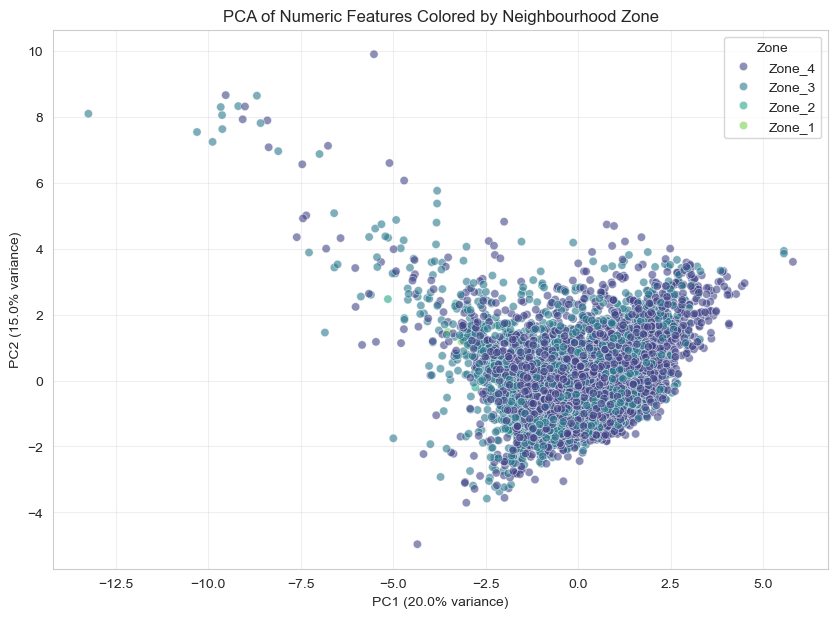

In [133]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric features only
numeric_cols = [
    "accommodates",
    "bathrooms",
    "amenities_count",
    "room_density",
    "days_since_host_signup",
    "days_since_last_review",
    "availability_rate",
    "number_of_reviews_log",
    "review_scores_cleanliness",
    "review_scores_location"
]

df_pca = listings_clean[numeric_cols + ["neighbourhood_zone"]].dropna()

# 1. Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca[numeric_cols])

# 2. PCA to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add back for plotting
df_pca["PC1"] = X_pca[:, 0]
df_pca["PC2"] = X_pca[:, 1]

# 3. Plot PCA with neighbourhood zones
plt.figure(figsize=(10,7))
sns.scatterplot(
    data=df_pca,
    x="PC1", y="PC2",
    hue="neighbourhood_zone",
    palette="viridis",
    alpha=0.6
)

plt.title("PCA of Numeric Features Colored by Neighbourhood Zone")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend(title="Zone")
plt.grid(True, alpha=0.3)
plt.show()
